# Trying to Cluster Human Atlas Data

# Clustering Failure Analysis on Human Protein Atlas Data

## **Project Goal**
I attempted to use **ResNet50 feature embeddings** to cluster images from the Human Protein Atlas dataset. The link to the dataset is in section 7 of this file.

The idea was to:  
1. **Cluster the images** using **DPGMM (Dirichlet Process Gaussian Mixture Model)** and **K-Means**.  
2. **Train separate neural networks** for each cluster, specializing in different image types.  
3. **Use the predicted cluster** at inference time to send each image to its corresponding specialized neural net.  

The hypothesis was that **specialized networks** would outperform a single model trained on the entire dataset.  

---

## **What Went Wrong?**
### **1️ Clustering Completely Failed**
- **DPGMM failed to converge**, with ELBO exploding to massive values.
- **K-Means produced clusters with near-zero silhouette scores** (no meaningful separations).
- **DBSCAN classified nearly everything as noise (-1)** (no dense groups detected).  

### **2️ The Root Cause: The Data Was Not Clusterable**
- **Shapiro-Wilk test showed extreme non-Gaussianity** in feature distributions.  
- **Skewness & Kurtosis confirmed heavy tails and non-normal behavior.**  
- **PCA visualizations showed no natural separations.**  
- **Ultimately, the dataset does not have meaningful clusters for unsupervised learning.**  

---

## **Key Takeaways: How to Detect Clustering Failures Early**
Through this process, I developed a **quick pipeline** to detect when clustering is a bad idea:  

### **Fast Clustering Failure Detection Workflow**
1 **Check Gaussianity First**  
   - Run **Shapiro-Wilk test**  
   - Check **Skewness & Kurtosis**  
   - If heavily non-Gaussian → **Avoid GMM-based methods**  

2️ **Run K-Means as a Baseline**  
   - Compute **Silhouette Score**  
   - If score **< 0.2**, data is likely **not separable**  
   - If **Elbow Method is flat**, there’s no real structure  

3️ **Try DBSCAN for Density-Based Clustering**  
   - If **everything gets labeled as noise (-1)**, the dataset lacks natural clusters  

---

## **Conclusion: Clustering is NOT a Viable Approach for This Dataset**
- The **dataset lacks natural separable clusters**, making **unsupervised learning infeasible**.  
- Instead, **supervised learning with CNNs or Vision Transformers is the correct approach**.  
- This analysis provides a **reliable workflow for detecting bad clustering problems early**, preventing wasted time on doomed models.  

---

**This project documents a real ML failure and provides a structured approach for debugging similar issues in the future.**  

---

# Contents:

- Section 1: Preparing the File
- Section 2: Test Section
- Section 3: Code for Entire Dataset
- Section 4: DPGMM Tests
- Section 5: K-Means
- Section 6: DBSCAN
- Section 7: Citations

# Section 1: Preparing the File

## Install all required libraries for the program

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff  # For loading .tif images
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm  # Import progress bar
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from pyro.optim import Adam
import pyro.optim as optim
import time
from scipy.stats import shapiro, skew, kurtosis
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.metrics import silhouette_score  
from sklearn.cluster import DBSCAN  

## Give Paths

All this does is give the paths to the folder containing the training images and the corresponding training labels.

In [2]:

# Define main dataset path
DATASET_PATH = r"D:\hpa-single-cell-image-classification"

# Define sub-paths
TRAIN_PATH = os.path.join(DATASET_PATH, "train")  # Path to training images
LABELS_PATH = os.path.join(DATASET_PATH, "train.csv")  # Path to labels CSV

# Print to verify
print("Train Path:", TRAIN_PATH)
print("Labels Path:", LABELS_PATH)

Train Path: D:\hpa-single-cell-image-classification\train
Labels Path: D:\hpa-single-cell-image-classification\train.csv


---

## Preparing the Dataset

## Load the Labels

In [3]:
df = pd.read_csv(LABELS_PATH)
print(df.head())  # Check first few rows

                                     ID  Label
0  5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0  8|5|0
1  5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0   14|0
2  60b57878-bb99-11e8-b2b9-ac1f6b6435d0    6|1
3  5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0  16|10
4  5b931256-bb99-11e8-b2b9-ac1f6b6435d0   14|0


## Loading a single image

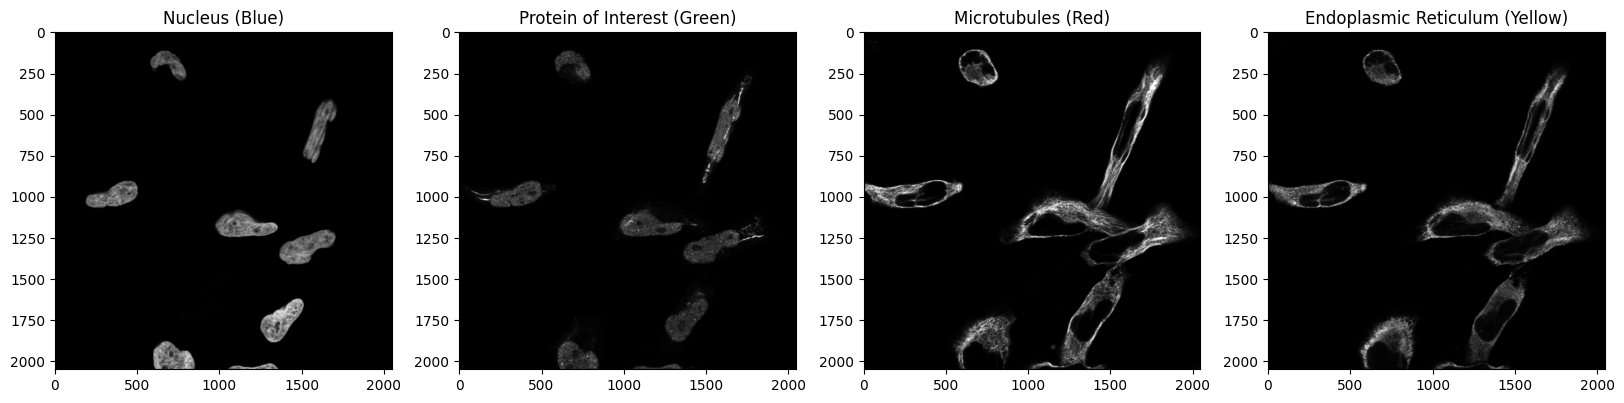

In [4]:
# Get first image ID from the CSV
sample_id = df.iloc[0]["ID"]

# Load each channel (CHANGE .tif to .png)
img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{sample_id}_blue.png"), cv2.IMREAD_UNCHANGED)
img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{sample_id}_green.png"), cv2.IMREAD_UNCHANGED)  # Protein of interest
img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{sample_id}_red.png"), cv2.IMREAD_UNCHANGED)
img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{sample_id}_yellow.png"), cv2.IMREAD_UNCHANGED)

# Convert images to RGB format for correct visualization
img_blue = cv2.cvtColor(img_blue, cv2.COLOR_BGR2RGB)
img_green = cv2.cvtColor(img_green, cv2.COLOR_BGR2RGB)
img_red = cv2.cvtColor(img_red, cv2.COLOR_BGR2RGB)
img_yellow = cv2.cvtColor(img_yellow, cv2.COLOR_BGR2RGB)

# Display images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(img_blue); axes[0].set_title("Nucleus (Blue)")
axes[1].imshow(img_green); axes[1].set_title("Protein of Interest (Green)")
axes[2].imshow(img_red); axes[2].set_title("Microtubules (Red)")
axes[3].imshow(img_yellow); axes[3].set_title("Endoplasmic Reticulum (Yellow)")
plt.show()

In [5]:
print("Blue Channel Shape:", img_blue.shape)
print("Green Channel Shape:", img_green.shape)  # This is the protein signal
print("Red Channel Shape:", img_red.shape)
print("Yellow Channel Shape:", img_yellow.shape)

# Check pixel range
print("Min Pixel Value:", np.min(img_green))
print("Max Pixel Value:", np.max(img_green))

Blue Channel Shape: (2048, 2048, 3)
Green Channel Shape: (2048, 2048, 3)
Red Channel Shape: (2048, 2048, 3)
Yellow Channel Shape: (2048, 2048, 3)
Min Pixel Value: 0
Max Pixel Value: 255


I will now try converting the images to grayscale and also kleep color images. We will then see which does better. 

---

## 1A: Non Grayscale

In [6]:
# Stack original RGB images into a single 12-channel tensor
img_stacked_rgb = np.concatenate([img_blue, img_green, img_red, img_yellow], axis=-1)
print("Non-Grayscale Shape:", img_stacked_rgb.shape)  # Should be (2048, 2048, 12)

Non-Grayscale Shape: (2048, 2048, 12)


## 1B: Grayscale

In [7]:
# Convert each channel to grayscale
img_blue_gray = cv2.cvtColor(img_blue, cv2.COLOR_RGB2GRAY)
img_green_gray = cv2.cvtColor(img_green, cv2.COLOR_RGB2GRAY)
img_red_gray = cv2.cvtColor(img_red, cv2.COLOR_RGB2GRAY)
img_yellow_gray = cv2.cvtColor(img_yellow, cv2.COLOR_RGB2GRAY)

# Stack grayscale images into a single 4-channel tensor
img_stacked_gray = np.stack([img_blue_gray, img_green_gray, img_red_gray, img_yellow_gray], axis=-1)
print("Grayscale Shape:", img_stacked_gray.shape)  # Should be (2048, 2048, 4)

Grayscale Shape: (2048, 2048, 4)


I will now use a CNN to get features of the pictures to run DP-GMM on them to cluster them. 

---
# Section 2: Test Section

Here I tested the code to make sure it works on only 10 images. If it failed it would not have taken an hour to run. I tested for the Green, the Multicolor, and the Grayscale images. Later, this same code would run on the entire dataset.

## Green test

In [8]:
# Load pretrained ResNet model and move to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V1").to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last FC layer
model.eval()

# Define transform (resize & normalize for CNN)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

def extract_cnn_features_green(img):
    """Extract features from the Green channel (Protein of Interest) using ResNet."""
    img_green = img[:, :, 1]  # ✅ Extract Green channel (index 1)

    # Convert single-channel grayscale to 3-channel by stacking
    img_green_3ch = np.stack([img_green, img_green, img_green], axis=-1)  # (H, W, 3)

    img_tensor = transform(img_green_3ch).unsqueeze(0).to(device)  # ✅ Move tensor to GPU
    with torch.no_grad():
        features = model(img_tensor)  # ✅ Model is on GPU
    return features.squeeze().cpu().numpy()  # ✅ Move result back to CPU for NumPy

# Directory where images are stored
TRAIN_PATH = "D:/hpa-single-cell-image-classification/train"
SAVE_PATH = "test_green_channel_features.npy"

# Get the first 10 images for testing
all_files = [f for f in os.listdir(TRAIN_PATH) if "_green.png" in f][:10]
num_images = len(all_files)
print(f"Processing {num_images} Green channel images...")

# Initialize or resume from existing file
if os.path.exists(SAVE_PATH):
    saved_features = np.load(SAVE_PATH)
    start_index = len(saved_features)
    all_features_green = list(saved_features)  # Convert back to list
    print(f"Resuming from index {start_index}/{num_images}...")
else:
    all_features_green = []
    start_index = 0

# Loop through the first 10 images
for i, filename in enumerate(tqdm(all_files[start_index:], desc="Extracting CNN Features", unit="image")):
    base_id = filename.replace("_green.png", "")

    # Load all four grayscale images (single-channel)
    img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_blue.png"), cv2.IMREAD_GRAYSCALE)
    img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_green.png"), cv2.IMREAD_GRAYSCALE)
    img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_red.png"), cv2.IMREAD_GRAYSCALE)
    img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_yellow.png"), cv2.IMREAD_GRAYSCALE)

    # Stack into (H, W, 4)
    img_stacked_rgb = np.stack([img_blue, img_green, img_red, img_yellow], axis=-1)

    # Extract features for this image
    features = extract_cnn_features_green(img_stacked_rgb)

    # Store in the list
    all_features_green.append(features)

    # Save after every image (since we only have 10, we save frequently)
    np.save(SAVE_PATH, np.array(all_features_green))
    print(f"Progress saved at {i + start_index + 1}/{num_images} images.")

# Final save
np.save(SAVE_PATH, np.array(all_features_green))
print("\nFeature extraction complete!")
print("Final Shape of Extracted Features (Green-Only):", np.array(all_features_green).shape)
print(f"Features saved successfully to '{SAVE_PATH}'")

Processing 10 Green channel images...
Resuming from index 10/10...


Extracting CNN Features: 0image [00:00, ?image/s]


Feature extraction complete!
Final Shape of Extracted Features (Green-Only): (10, 2048)
Features saved successfully to 'test_green_channel_features.npy'


Making sure the output is the correct shape. 

In [9]:
# Load the saved features
features_green = np.load("test_green_channel_features.npy")

# Print shape
print("Loaded Feature Shape:", features_green.shape)  # Should be (10, 2048)

# Confirm we have exactly 10 vectors
if features_green.shape[0] == 10:
    print("✅ The file contains 10 feature vectors.")
else:
    print("❌ Something is wrong! The file has", features_green.shape[0], "vectors.")

Loaded Feature Shape: (10, 2048)
✅ The file contains 10 feature vectors.


Making sure the feature vectors are unique. I was checking to see if the model was saving correctly. 

In [10]:
# Load features
features_green = np.load("test_green_channel_features.npy")

# Compute differences between consecutive vectors
diffs = np.diff(features_green, axis=0)

# Count how many vectors are identical
identical_vectors = np.sum(np.all(diffs == 0, axis=1))

if identical_vectors == 0:
    print("✅ All feature vectors are unique.")
else:
    print(f"❌ {identical_vectors} feature vectors are duplicates!")

✅ All feature vectors are unique.


A visual inspection of some of the vectors.

In [11]:
for i in range(3):  # Print first 3 vectors
    print(f"\nFeature Vector {i + 1} (First 10 values):", features_green[i][:10])


Feature Vector 1 (First 10 values): [0.29302487 0.04274444 0.11188141 0.04832537 0.3410959  0.11987651
 0.06801521 0.23648635 0.15759343 0.26365858]

Feature Vector 2 (First 10 values): [0.12924342 0.0062368  0.06034244 0.01250822 0.04183471 0.10449719
 0.06112994 0.1447379  0.1598235  0.27098748]

Feature Vector 3 (First 10 values): [0.10735136 0.03982344 0.3241333  0.04077918 0.1407369  0.4294225
 0.08831063 0.63315326 0.14994392 0.32936865]


## Multicolor Test

In [12]:
# Load pretrained ResNet model and move to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V1").to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last FC layer
model.eval()

# Define transform (normalize and resize for CNN)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match CNN input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize intensity
])

def create_pseudo_rgb(img):
    """Convert 4-channel image into a 3-channel (R-G-B) image."""
    r = img[:, :, 2]  # Use Red channel (Microtubules)
    g = img[:, :, 3]  # Use Green channel (Protein of Interest)
    b = img[:, :, 0]  # Use Blue channel (Nucleus)
    
    pseudo_rgb = np.stack([r, g, b], axis=-1)  # Stack into (H, W, 3)
    return pseudo_rgb.astype(np.uint8)  # Ensure proper dtype

def extract_cnn_features_pseudo_rgb(img):
    """Extract features from a Pseudo-RGB image using ResNet."""
    img_tensor = transform(img).unsqueeze(0).to(device)  # ✅ Move tensor to GPU
    with torch.no_grad():
        features = model(img_tensor)  # ✅ Model is on GPU
    return features.squeeze().cpu().numpy()  # ✅ Move result back to CPU for NumPy

# Directory where images are stored
TRAIN_PATH = "D:/hpa-single-cell-image-classification/train"
SAVE_PATH = "test_pseudo_rgb_features.npy"

# Get list of first 10 images for testing
all_files = [f for f in os.listdir(TRAIN_PATH) if "_green.png" in f][:10]
num_images = len(all_files)
print(f"Processing {num_images} Pseudo-RGB images...\n")

# Initialize or resume from existing file
if os.path.exists(SAVE_PATH):
    saved_features = np.load(SAVE_PATH)
    start_index = len(saved_features)
    all_features_pseudo_rgb = list(saved_features)  # Convert back to list
    print(f"Resuming from index {start_index}/{num_images}...")
else:
    all_features_pseudo_rgb = []
    start_index = 0

# Loop through first 10 images
for i, filename in enumerate(tqdm(all_files[start_index:], desc="Extracting CNN Features (Pseudo-RGB)", unit="image")):
    base_id = filename.replace("_green.png", "")

    # Load all four images as grayscale (single-channel)
    img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_blue.png"), cv2.IMREAD_GRAYSCALE)
    img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_green.png"), cv2.IMREAD_GRAYSCALE)
    img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_red.png"), cv2.IMREAD_GRAYSCALE)
    img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_yellow.png"), cv2.IMREAD_GRAYSCALE)

    # Stack into (H, W, 4)
    img_stacked_rgb = np.stack([img_blue, img_green, img_red, img_yellow], axis=-1)

    # Convert to Pseudo-RGB
    pseudo_rgb_image = create_pseudo_rgb(img_stacked_rgb)

    # Extract features
    features = extract_cnn_features_pseudo_rgb(pseudo_rgb_image)

    # Store in the list
    all_features_pseudo_rgb.append(features)

    # Save after every image (for testing)
    np.save(SAVE_PATH, np.array(all_features_pseudo_rgb))
    print(f"Progress saved at {i + start_index + 1}/{num_images} images.")

# Final save
np.save(SAVE_PATH, np.array(all_features_pseudo_rgb))
print("\nFeature extraction complete!")
print("Final Shape of Extracted Features (Pseudo-RGB):", np.array(all_features_pseudo_rgb).shape)
print(f"Features saved successfully to '{SAVE_PATH}'")

Processing 10 Pseudo-RGB images...

Resuming from index 10/10...


Extracting CNN Features (Pseudo-RGB): 0image [00:00, ?image/s]


Feature extraction complete!
Final Shape of Extracted Features (Pseudo-RGB): (10, 2048)
Features saved successfully to 'test_pseudo_rgb_features.npy'


Checking the shape of the vectors again, making sure that they are the correct shape.

In [13]:
# Load extracted feature files
features_green = np.load("test_green_channel_features.npy")  # Green-Only features
features_pseudo_rgb = np.load("test_pseudo_rgb_features.npy")  # Pseudo-RGB features

print("Loaded Green-Only Feature Shape:", features_green.shape)
print("Loaded Pseudo-RGB Feature Shape:", features_pseudo_rgb.shape)

Loaded Green-Only Feature Shape: (10, 2048)
Loaded Pseudo-RGB Feature Shape: (10, 2048)


Checking if there are differences between the absolute features, if there wasn't then there would be no need for different datasets.

In [14]:
diff = np.abs(features_green - features_pseudo_rgb)
print("Mean Absolute Feature Difference:", np.mean(diff))
print("Max Absolute Feature Difference:", np.max(diff))

Mean Absolute Feature Difference: 0.2765433
Max Absolute Feature Difference: 3.898373


## Gray Test

In [15]:
# Load pretrained ResNet model and move to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V1").to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last FC layer
model.eval()

# Define transform (normalize and resize for CNN)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match CNN input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize intensity
])

def convert_4ch_to_3ch(img_4ch):
    """Convert 4-channel grayscale image to 3-channel for ResNet."""
    r = img_4ch[:, :, 0]  # Blue (Nucleus)
    g = img_4ch[:, :, 1]  # Green (Protein of Interest)
    b = (img_4ch[:, :, 2] + img_4ch[:, :, 3]) / 2  # Merge Red (Microtubules) & Yellow (ER)

    grayscale_3ch = np.stack([r, g, b], axis=-1)  # Shape: (H, W, 3)
    return np.clip(grayscale_3ch, 0, 255).astype(np.uint8)  # Ensure valid pixel range

def extract_cnn_features_grayscale(img):
    """Extract features from the 3-channel grayscale image using ResNet."""
    img_tensor = transform(img).unsqueeze(0).to(device)  # Convert to tensor & move to GPU
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().cpu().numpy()  # Move result back to CPU for NumPy

# Directory where images are stored
TRAIN_PATH = "D:/hpa-single-cell-image-classification/train"
SAVE_PATH = "test_grayscale_3ch_features.npy"

# Get first 10 images for testing
all_files = [f for f in os.listdir(TRAIN_PATH) if "_green.png" in f][:10]
num_images = len(all_files)

print(f"Processing {num_images} Grayscale 3-Channel images...\n")

# Initialize or resume from existing file
if os.path.exists(SAVE_PATH):
    saved_features = np.load(SAVE_PATH)
    start_index = len(saved_features)
    all_features_grayscale = list(saved_features)  # Convert back to list
    print(f"Resuming from index {start_index}/{num_images}...")
else:
    all_features_grayscale = []
    start_index = 0

# Loop through 10 images with a progress bar
for i, filename in enumerate(tqdm(all_files[start_index:], desc="Extracting CNN Features (Grayscale 3-CH)", unit="image")):
    base_id = filename.replace("_green.png", "")

    # Load all four grayscale images (single-channel)
    img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_blue.png"), cv2.IMREAD_GRAYSCALE)
    img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_green.png"), cv2.IMREAD_GRAYSCALE)
    img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_red.png"), cv2.IMREAD_GRAYSCALE)
    img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_yellow.png"), cv2.IMREAD_GRAYSCALE)

    # Stack into (H, W, 4)
    img_stacked_gray = np.stack([img_blue, img_green, img_red, img_yellow], axis=-1)

    # Convert to 3-channel grayscale
    img_grayscale_3ch = convert_4ch_to_3ch(img_stacked_gray)

    # Extract features for this image
    features = extract_cnn_features_grayscale(img_grayscale_3ch)

    # Store feature vector
    all_features_grayscale.append(features)

    # Save after every image (for testing)
    np.save(SAVE_PATH, np.array(all_features_grayscale))
    print(f"Progress saved at {i + start_index + 1}/{num_images} images.")

# Final save
np.save(SAVE_PATH, np.array(all_features_grayscale))
print("\nFeature extraction complete!")
print("Final Shape of Extracted Features (Grayscale 3-Channel):", np.array(all_features_grayscale).shape)
print(f"Features saved successfully to '{SAVE_PATH}'")

Processing 10 Grayscale 3-Channel images...

Resuming from index 10/10...


Extracting CNN Features (Grayscale 3-CH): 0image [00:00, ?image/s]


Feature extraction complete!
Final Shape of Extracted Features (Grayscale 3-Channel): (10, 2048)
Features saved successfully to 'test_grayscale_3ch_features.npy'


Checking the shapes of the vectors to see if they are correct.

In [16]:
# Load extracted feature files
features_green = np.load("test_green_channel_features.npy")  # Green-Only
features_pseudo_rgb = np.load("test_pseudo_rgb_features.npy")  # Pseudo-RGB
features_grayscale = np.load("test_grayscale_3ch_features.npy")  # Grayscale 3-CH

print("Feature Shapes:")
print("Green-Only:", features_green.shape)
print("Pseudo-RGB:", features_pseudo_rgb.shape)
print("Grayscale 3-CH:", features_grayscale.shape)

Feature Shapes:
Green-Only: (10, 2048)
Pseudo-RGB: (10, 2048)
Grayscale 3-CH: (10, 2048)


Checking to see if the datasets are different through checking mean features.

In [17]:
diff_green_gray = np.abs(features_green - features_grayscale)
diff_pseudo_gray = np.abs(features_pseudo_rgb - features_grayscale)

print("\nMean Absolute Feature Difference (Green vs Grayscale):", np.mean(diff_green_gray))
print("Max Absolute Feature Difference (Green vs Grayscale):", np.max(diff_green_gray))

print("\nMean Absolute Feature Difference (Pseudo-RGB vs Grayscale):", np.mean(diff_pseudo_gray))
print("Max Absolute Feature Difference (Pseudo-RGB vs Grayscale):", np.max(diff_pseudo_gray))


Mean Absolute Feature Difference (Green vs Grayscale): 0.22646299
Max Absolute Feature Difference (Green vs Grayscale): 4.031078

Mean Absolute Feature Difference (Pseudo-RGB vs Grayscale): 0.19951878
Max Absolute Feature Difference (Pseudo-RGB vs Grayscale): 3.5894268


A simple PCA of these tests, to visualize the datasets.

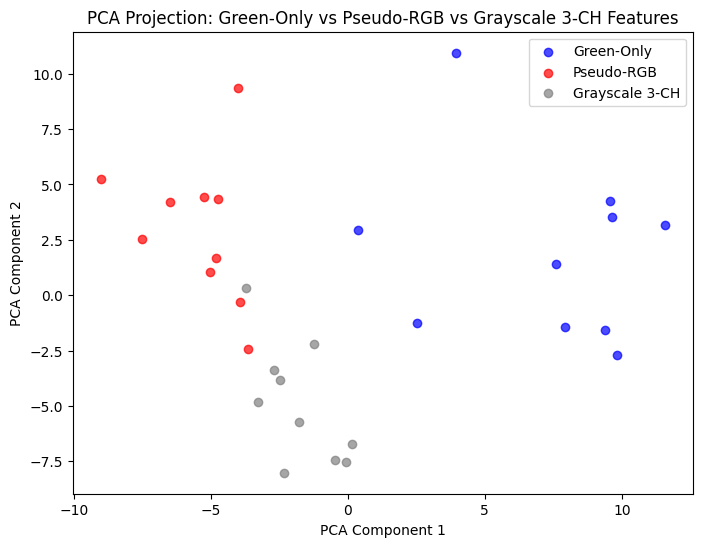

In [18]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
features_combined = np.vstack((features_green, features_pseudo_rgb, features_grayscale))  # Stack all feature sets
features_2d = pca.fit_transform(features_combined)

# Plot Green-Only vs Pseudo-RGB vs Grayscale 3-CH
plt.figure(figsize=(8,6))
plt.scatter(features_2d[:10, 0], features_2d[:10, 1], label="Green-Only", alpha=0.7, color="blue")
plt.scatter(features_2d[10:20, 0], features_2d[10:20, 1], label="Pseudo-RGB", alpha=0.7, color="red")
plt.scatter(features_2d[20:, 0], features_2d[20:, 1], label="Grayscale 3-CH", alpha=0.7, color="gray")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection: Green-Only vs Pseudo-RGB vs Grayscale 3-CH Features")
plt.legend()
plt.show()

## **Next, I will run the program on the entire dataset.**

---
# Section 3: Code for Entire Dataset

## For Green Channel only

In [19]:
# Load pretrained ResNet model and move to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V1").to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last FC layer
model.eval()

# Define transform (resize & normalize for CNN)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

def extract_cnn_features_green(img):
    """Extract features from the Green channel (Protein of Interest) using ResNet."""
    img_green = img[:, :, 1]  # ✅ Extract Green channel (index 1)

    # Convert single-channel grayscale to 3-channel by stacking
    img_green_3ch = np.stack([img_green, img_green, img_green], axis=-1)  # (H, W, 3)

    img_tensor = transform(img_green_3ch).unsqueeze(0).to(device)  # ✅ Move tensor to GPU
    with torch.no_grad():
        features = model(img_tensor)  # ✅ Model is on GPU
    return features.squeeze().cpu().numpy()  # ✅ Move result back to CPU for NumPy

# Directory where images are stored
TRAIN_PATH = "D:/hpa-single-cell-image-classification/train"
SAVE_PATH = "green_channel_features.npy"

# Get all images
all_files = [f for f in os.listdir(TRAIN_PATH) if "_green.png" in f]
num_images = len(all_files)

print(f"Processing {num_images} Green channel images...\n")

# Initialize or resume from existing file
if os.path.exists(SAVE_PATH):
    saved_features = np.load(SAVE_PATH)
    start_index = len(saved_features)
    all_features_green = list(saved_features)  # Convert back to list
    print(f"Resuming from index {start_index}/{num_images}...")
else:
    all_features_green = []
    start_index = 0

# Loop through all images
for i, filename in enumerate(tqdm(all_files[start_index:], desc="Extracting CNN Features", unit="image")):
    base_id = filename.replace("_green.png", "")

    # Load all four grayscale images (single-channel)
    img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_blue.png"), cv2.IMREAD_GRAYSCALE)
    img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_green.png"), cv2.IMREAD_GRAYSCALE)
    img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_red.png"), cv2.IMREAD_GRAYSCALE)
    img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_yellow.png"), cv2.IMREAD_GRAYSCALE)

    # Stack into (H, W, 4)
    img_stacked_rgb = np.stack([img_blue, img_green, img_red, img_yellow], axis=-1)

    # Extract features for this image
    features = extract_cnn_features_green(img_stacked_rgb)

    # Store in the list
    all_features_green.append(features)

    # Save every 100 images (prevents data loss)
    if (i + start_index + 1) % 100 == 0:
        np.save(SAVE_PATH, np.array(all_features_green))
        print(f"Progress saved at {i + start_index + 1}/{num_images} images.")

# Final save
np.save(SAVE_PATH, np.array(all_features_green))
print("\nFeature extraction complete!")
print("Final Shape of Extracted Features (Green-Only):", np.array(all_features_green).shape)
print(f"Features saved successfully to '{SAVE_PATH}'")

Processing 21806 Green channel images...

Resuming from index 21806/21806...


Extracting CNN Features: 0image [00:00, ?image/s]



Feature extraction complete!
Final Shape of Extracted Features (Green-Only): (21806, 2048)
Features saved successfully to 'green_channel_features.npy'


## For multicolor

In [20]:
# Load pretrained ResNet model and move to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V1").to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last FC layer
model.eval()

# Define transform (normalize and resize for CNN)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match CNN input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize intensity
])

def create_pseudo_rgb(img):
    """Convert 4-channel image into a 3-channel (R-G-B) image."""
    r = img[:, :, 2]  # Use Red channel (Microtubules)
    g = img[:, :, 3]  # Use Green channel (Protein of Interest)
    b = img[:, :, 0]  # Use Blue channel (Nucleus)
    
    pseudo_rgb = np.stack([r, g, b], axis=-1)  # Stack into (H, W, 3)
    return pseudo_rgb.astype(np.uint8)  # Ensure proper dtype

def extract_cnn_features_pseudo_rgb(img):
    """Extract features from a Pseudo-RGB image using ResNet."""
    img_tensor = transform(img).unsqueeze(0).to(device)  # ✅ Move tensor to GPU
    with torch.no_grad():
        features = model(img_tensor)  # ✅ Model is on GPU
    return features.squeeze().cpu().numpy()  # ✅ Move result back to CPU for NumPy

# Directory where images are stored
TRAIN_PATH = "D:/hpa-single-cell-image-classification/train"
SAVE_PATH = "pseudo_rgb_features.npy"

# Get all images
all_files = [f for f in os.listdir(TRAIN_PATH) if "_green.png" in f]
num_images = len(all_files)

print(f"Processing {num_images} Pseudo-RGB images...\n")

# Initialize or resume from existing file
if os.path.exists(SAVE_PATH):
    saved_features = np.load(SAVE_PATH)
    start_index = len(saved_features)
    all_features_pseudo_rgb = list(saved_features)  # Convert back to list
    print(f"Resuming from index {start_index}/{num_images}...")
else:
    all_features_pseudo_rgb = []
    start_index = 0

# Loop through all images
for i, filename in enumerate(tqdm(all_files[start_index:], desc="Extracting CNN Features (Pseudo-RGB)", unit="image")):
    base_id = filename.replace("_green.png", "")

    # Load all four images as grayscale (single-channel)
    img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_blue.png"), cv2.IMREAD_GRAYSCALE)
    img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_green.png"), cv2.IMREAD_GRAYSCALE)
    img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_red.png"), cv2.IMREAD_GRAYSCALE)
    img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_yellow.png"), cv2.IMREAD_GRAYSCALE)

    # Stack into (H, W, 4)
    img_stacked_rgb = np.stack([img_blue, img_green, img_red, img_yellow], axis=-1)

    # Convert to Pseudo-RGB
    pseudo_rgb_image = create_pseudo_rgb(img_stacked_rgb)

    # Extract features
    features = extract_cnn_features_pseudo_rgb(pseudo_rgb_image)

    # Store in the list
    all_features_pseudo_rgb.append(features)

    # Save every 100 images (to prevent data loss)
    if (i + start_index + 1) % 100 == 0:
        np.save(SAVE_PATH, np.array(all_features_pseudo_rgb))
        print(f"Progress saved at {i + start_index + 1}/{num_images} images.")

# Final save
np.save(SAVE_PATH, np.array(all_features_pseudo_rgb))
print("\nFeature extraction complete!")
print("Final Shape of Extracted Features (Pseudo-RGB):", np.array(all_features_pseudo_rgb).shape)
print(f"Features saved successfully to '{SAVE_PATH}'")

Processing 21806 Pseudo-RGB images...

Resuming from index 21806/21806...


Extracting CNN Features (Pseudo-RGB): 0image [00:00, ?image/s]



Feature extraction complete!
Final Shape of Extracted Features (Pseudo-RGB): (21806, 2048)
Features saved successfully to 'pseudo_rgb_features.npy'


## For Grayscale made on 1B

This averages together Red and Yellow, mictotubules and ER together into one single layer. Then Resnet, which takes 3 layers, can take this four layer data. 

In [21]:
# Load pretrained ResNet model and move to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights="IMAGENET1K_V1").to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove last FC layer
model.eval()

# Define transform (normalize and resize for CNN)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match CNN input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize intensity
])

def convert_4ch_to_3ch(img_4ch):
    """Convert 4-channel grayscale image to 3-channel for ResNet."""
    r = img_4ch[:, :, 0]  # Blue (Nucleus)
    g = img_4ch[:, :, 1]  # Green (Protein of Interest)
    b = (img_4ch[:, :, 2] + img_4ch[:, :, 3]) / 2  # Merge Red (Microtubules) & Yellow (ER)

    grayscale_3ch = np.stack([r, g, b], axis=-1)  # Shape: (H, W, 3)
    return np.clip(grayscale_3ch, 0, 255).astype(np.uint8)  # Ensure valid pixel range

def extract_cnn_features_grayscale(img):
    """Extract features from the 3-channel grayscale image using ResNet."""
    img_tensor = transform(img).unsqueeze(0).to(device)  # Convert to tensor & move to GPU
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().cpu().numpy()  # Move result back to CPU for NumPy

# Directory where images are stored
TRAIN_PATH = "D:/hpa-single-cell-image-classification/train"
SAVE_PATH = "grayscale_3ch_features.npy"

# Get all images
all_files = [f for f in os.listdir(TRAIN_PATH) if "_green.png" in f]
num_images = len(all_files)

print(f"Processing {num_images} Grayscale 3-Channel images...\n")

# Initialize or resume from existing file
if os.path.exists(SAVE_PATH):
    saved_features = np.load(SAVE_PATH)
    start_index = len(saved_features)
    all_features_grayscale = list(saved_features)  # Convert back to list
    print(f"Resuming from index {start_index}/{num_images}...")
else:
    all_features_grayscale = []
    start_index = 0

# Loop through all images
for i, filename in enumerate(tqdm(all_files[start_index:], desc="Extracting CNN Features (Grayscale 3-CH)", unit="image")):
    base_id = filename.replace("_green.png", "")

    # Load all four grayscale images (single-channel)
    img_blue = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_blue.png"), cv2.IMREAD_GRAYSCALE)
    img_green = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_green.png"), cv2.IMREAD_GRAYSCALE)
    img_red = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_red.png"), cv2.IMREAD_GRAYSCALE)
    img_yellow = cv2.imread(os.path.join(TRAIN_PATH, f"{base_id}_yellow.png"), cv2.IMREAD_GRAYSCALE)

    # Stack into (H, W, 4)
    img_stacked_gray = np.stack([img_blue, img_green, img_red, img_yellow], axis=-1)

    # Convert to 3-channel grayscale
    img_grayscale_3ch = convert_4ch_to_3ch(img_stacked_gray)

    # Extract features
    features = extract_cnn_features_grayscale(img_grayscale_3ch)

    # Store feature vector
    all_features_grayscale.append(features)

    # Save every 100 images (to prevent data loss)
    if (i + start_index + 1) % 100 == 0:
        np.save(SAVE_PATH, np.array(all_features_grayscale))
        print(f"Progress saved at {i + start_index + 1}/{num_images} images.")

# Final save
np.save(SAVE_PATH, np.array(all_features_grayscale))
print("\nFeature extraction complete!")
print("Final Shape of Extracted Features (Grayscale 3-Channel):", np.array(all_features_grayscale).shape)
print(f"Features saved successfully to '{SAVE_PATH}'")

Processing 21806 Grayscale 3-Channel images...

Resuming from index 21806/21806...


Extracting CNN Features (Grayscale 3-CH): 0image [00:00, ?image/s]



Feature extraction complete!
Final Shape of Extracted Features (Grayscale 3-Channel): (21806, 2048)
Features saved successfully to 'grayscale_3ch_features.npy'


---
## PCA on the entire dataset

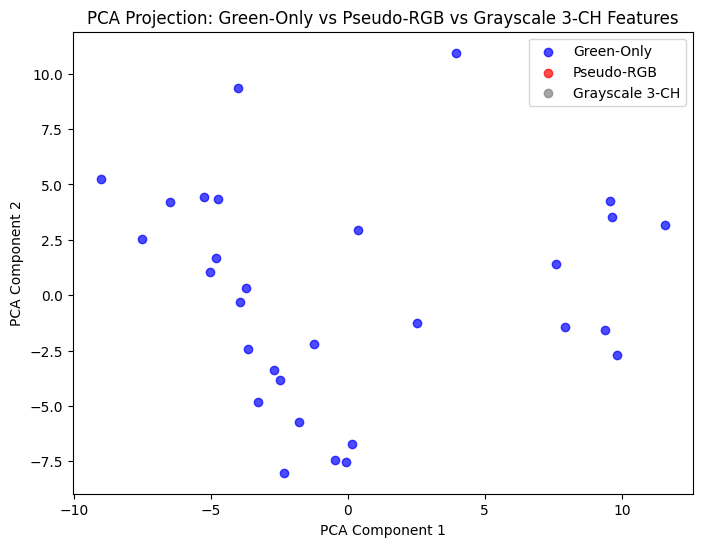

In [22]:
features_green = np.load("green_channel_features.npy")  # Entire dataset features
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")


# Reduce to 2D for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_combined)
plt.figure(figsize=(8,6))
num_images = features_green.shape[0]

plt.scatter(features_2d[:num_images, 0], features_2d[:num_images, 1], label="Green-Only", alpha=0.7, color="blue")
plt.scatter(features_2d[num_images:2*num_images, 0], features_2d[num_images:2*num_images, 1], label="Pseudo-RGB", alpha=0.7, color="red")
plt.scatter(features_2d[2*num_images:, 0], features_2d[2*num_images:, 1], label="Grayscale 3-CH", alpha=0.7, color="gray")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection: Green-Only vs Pseudo-RGB vs Grayscale 3-CH Features")
plt.legend()
plt.show()

As can be seen some components are massive and some are not. The graph only shows the green due to this mismatch. In order to fix this, I will standardize the features.

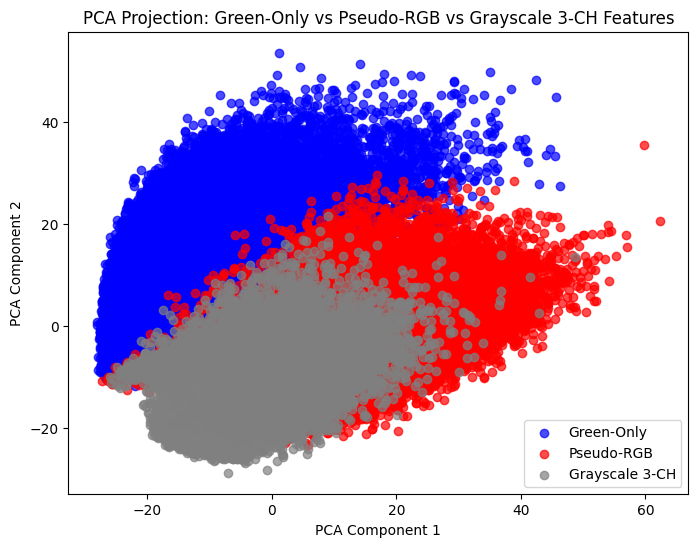

In [23]:
# Load all feature sets
features_green = np.load("green_channel_features.npy")  
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")

# Stack all feature sets into one array
features_combined = np.vstack((features_green, features_pseudo_rgb, features_grayscale))

# Standardize the features to have mean=0 and std=1
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_combined)

# Perform PCA reduction
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Define number of images in each feature set
num_images = features_green.shape[0]

# Plot PCA projections
plt.figure(figsize=(8,6))
plt.scatter(features_2d[:num_images, 0], features_2d[:num_images, 1], label="Green-Only", alpha=0.7, color="blue")
plt.scatter(features_2d[num_images:2*num_images, 0], features_2d[num_images:2*num_images, 1], label="Pseudo-RGB", alpha=0.7, color="red")
plt.scatter(features_2d[2*num_images:, 0], features_2d[2*num_images:, 1], label="Grayscale 3-CH", alpha=0.7, color="gray")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection: Green-Only vs Pseudo-RGB vs Grayscale 3-CH Features")
plt.legend()
plt.show()

Much better! The PCA now shows all the datasets. 3 Different populations have been created, each with different charecteristics. Now I will try to cluster each population. 

---
# Section 4: DPGMM TESTS

DPGMM is a Dirichlet Process GMM. It is a soft clustering algorithm, which means that a datapoint can belong to multiple clusters. GMM fits Gaussians to the datasets as shown in the Stanford CS229 Notes. The following tests, which do not appear in the notes, will show whether the data is Gaussian or non-Gaussian. If it is non-Gaussian the GMM will fail. If it is Gaussian the GMM will work.

1. Shapiro-Wilk p-value

    - The Shapiro-Wilk test checks normality.
    - Null hypothesis **H0**: The data is normally distributed.
    - Alternative hypothesis **Ha**: The data is not normally distributed.
    - If p-value < 0.05, we reject **H0**, meaning the data is not normal.

2. Skewness

    - Gaussian distributions have skewness = 0.
    - Skewness > 0 → Right-skewed (long right tail).
    - Skewness < 0 → Left-skewed (long left tail).
    - If skewness is between -0.5 and 0.5, it's approximately symmetric.

3. Kurtosis

    - Gaussian distributions have kurtosis = 0 (excess kurtosis).
    - Kurtosis > 0 → Heavy tails (leptokurtic, outlier-prone).
    - Kurtosis < 0 → Light tails (platykurtic, fewer outliers).
    - Kurtosis between -1 and 1 is close to normal.

In [24]:
features_grayscale = np.load("grayscale_3ch_features.npy") # ✅ Load features 

# ✅ Sample a subset (to speed up computation) 
subset_size = 5000 
features_grayscale = features_grayscale[:subset_size] 


# ✅ Pick 5 random features from each dataset 
np.random.seed(42)
random_features_gray = np.random.choice(features_grayscale.shape[1], size=5, replace=False)  

# ✅ Analyze each feature in Grayscale 
print("\n📊 **Grayscale Features**") 
for feature_idx in random_features_gray:     
    stat, p_value = shapiro(features_grayscale[:, feature_idx])     
    skewness = skew(features_grayscale[:, feature_idx])     
    kurt = kurtosis(features_grayscale[:, feature_idx])      
    print(f"🔍 Feature {feature_idx}:")     
    print(f"   - Shapiro-Wilk p-value = {p_value}")    
    print(f"   - Skewness = {skewness}")    
    print(f"   - Kurtosis = {kurt}\n") 


📊 **Grayscale Features**
🔍 Feature 1476:
   - Shapiro-Wilk p-value = 1.2277534791977091e-13
   - Skewness = 0.19170458614826202
   - Kurtosis = -0.2856302261352539

🔍 Feature 693:
   - Shapiro-Wilk p-value = 5.087689126701589e-62
   - Skewness = 2.615861415863037
   - Kurtosis = 13.561407089233398

🔍 Feature 100:
   - Shapiro-Wilk p-value = 9.587435478823041e-68
   - Skewness = 2.6329152584075928
   - Kurtosis = 10.007810592651367

🔍 Feature 1421:
   - Shapiro-Wilk p-value = 3.3596959063066087e-62
   - Skewness = 1.9867298603057861
   - Kurtosis = 4.817906856536865

🔍 Feature 1810:
   - Shapiro-Wilk p-value = 1.5588105121256392e-47
   - Skewness = 1.257519006729126
   - Kurtosis = 1.9754624366760254



## Results: 

- Feature 1476: Not Gaussian due to very small p-value.
- Feature 693: Not Gaussian due to skew and heavy tails.
- Feature 100: Not Gaussian due to skew and heavy tails.
- Fature 1421: Not Gaussian due to skew and heavy tails.
- Feature 1810: Not Gaussian due to skew and heavy tails.

In [25]:
features_pseudo_rgb = np.load("pseudo_rgb_features.npy") 
 

# ✅ Sample a subset (to speed up computation) 
subset_size = 5000 
features_pseudo_rgb = features_pseudo_rgb[:subset_size] 
features_grayscale = features_grayscale[:subset_size]  

# ✅ Pick 5 random features from each dataset 
np.random.seed(42) 
random_features_pseudo = np.random.choice(features_pseudo_rgb.shape[1], size=5, replace=False) 
random_features_gray = np.random.choice(features_grayscale.shape[1], size=5, replace=False)  
# ✅ Analyze each feature in Pseudo-RGB 
print("\n📊 **Pseudo-RGB Features**") 
for feature_idx in random_features_pseudo:     
    stat, p_value = shapiro(features_pseudo_rgb[:, feature_idx])     
    skewness = skew(features_pseudo_rgb[:, feature_idx])     
    kurt = kurtosis(features_pseudo_rgb[:, feature_idx])      
    print(f"🔍 Feature {feature_idx}:")     
    print(f"   - Shapiro-Wilk p-value = {p_value}")     
    print(f"   - Skewness = {skewness}")     
    print(f"   - Kurtosis = {kurt}\n")  


📊 **Pseudo-RGB Features**
🔍 Feature 1476:
   - Shapiro-Wilk p-value = 3.3332337163934453e-44
   - Skewness = 1.0011872053146362
   - Kurtosis = 0.7486088275909424

🔍 Feature 693:
   - Shapiro-Wilk p-value = 1.0281386382521527e-70
   - Skewness = 3.30631685256958
   - Kurtosis = 16.791770935058594

🔍 Feature 100:
   - Shapiro-Wilk p-value = 5.110100045615888e-74
   - Skewness = 3.0650010108947754
   - Kurtosis = 12.008559226989746

🔍 Feature 1421:
   - Shapiro-Wilk p-value = 3.8625144944274725e-68
   - Skewness = 2.5748519897460938
   - Kurtosis = 8.59323787689209

🔍 Feature 1810:
   - Shapiro-Wilk p-value = 1.4931655970913275e-47
   - Skewness = 1.2199110984802246
   - Kurtosis = 1.9063057899475098



## Results:

- None of these features are Gaussian because their p-values are extremely low.
- Features 693, 100, and 1421 are heavily skewed and have extreme kurtosis, indicating high asymmetry and heavy tails (outliers).
- Feature 1476 is the closest to Gaussian with moderate skew and kurtosis, but its p-value still rejects normality.
- Feature 1810 has moderate skew/kurtosis but is still not Gaussian.

In [26]:
# ✅ Load features
features_green = np.load("green_channel_features.npy")

# ✅ Sample a subset
subset_size = 5000
features_green = features_green[:subset_size]

# ✅ Pick 5 random features
np.random.seed(42)
random_features = np.random.choice(features_green.shape[1], size=5, replace=False)

# ✅ Analyze each feature
for feature_idx in random_features:
    stat, p_value = shapiro(features_green[:, feature_idx])
    skewness = skew(features_green[:, feature_idx])
    kurt = kurtosis(features_green[:, feature_idx])

    print(f"\n🔍 Feature {feature_idx}:")
    print(f"   - Shapiro-Wilk p-value = {p_value}")
    print(f"   - Skewness = {skewness}")
    print(f"   - Kurtosis = {kurt}")


🔍 Feature 1476:
   - Shapiro-Wilk p-value = 1.7376991952306304e-41
   - Skewness = 0.915422260761261
   - Kurtosis = 0.7310400009155273

🔍 Feature 693:
   - Shapiro-Wilk p-value = 2.0710573197417955e-69
   - Skewness = 3.2119314670562744
   - Kurtosis = 16.001455307006836

🔍 Feature 100:
   - Shapiro-Wilk p-value = 2.1823774381507063e-50
   - Skewness = 1.3446725606918335
   - Kurtosis = 2.3417582511901855

🔍 Feature 1421:
   - Shapiro-Wilk p-value = 2.3623539712408017e-44
   - Skewness = 0.9892361760139465
   - Kurtosis = 0.835646390914917

🔍 Feature 1810:
   - Shapiro-Wilk p-value = 3.8894516500570287e-69
   - Skewness = 2.476625919342041
   - Kurtosis = 7.6250715255737305


## Results: 
- None of these features are Gaussian, as all have very low p-values.
- Features 693 and 1810 are the most non-Gaussian, with high skewness and extreme kurtosis (long-tailed distributions).
- Features 1476 and 1421 are the closest to normal but still fail normality tests due to moderate skew and heavy tails.

## Running the DPGMM

GMM algorithms use ELBO to work. A full derivation is available in the Stanford CS229 Notes, Chapter 11.3

$$
\sum_{i} \mathbb{E}_{Q_i(z^{(i)})} \left[ \log p(x^{(i)} \mid z^{(i)}; \theta) \right]
$$
Is the formula for ELBO as per 11.3 in the Stanford CS229 Notes. 

$$
\sum_{i} \sum_{z^{(i)}} Q_i(z^{(i)}) \log p(x^{(i)} \mid z^{(i)}; \theta)
$$
Is the ELBO expanded.

A further expansion gives:

$$
\sum_{i} \sum_{z^{(i)}} Q_i(z^{(i)}) \log \frac{p(x^{(i)}, z^{(i)}; \theta)}{Q_i(z^{(i)})}
$$

Here we see the variance term in the numerator. As we shall see, the variance will explode as the DPGMM attempts to fit Gaussian distributions to non-Gaussian distributions. We should expect massive ELBO values.

A common failure mode of DPGMM is a massive ELBO which can be caused by non-Gaussian data, as the following tests will show.

Checking for NaNs...
Warm Start Enabled: True

Fitting DP-GMM on Green-Only Features with Manual Iteration Tracking...
Initialization 0
Initialization converged. time lapse 99.78109s	 lower bound 625719248.87576.
Iteration 1, ELBO: 625719248.8757557
Initialization 0
Initialization converged. time lapse 73.71929s	 lower bound 625719248.87576.
Iteration 2, Mean Shift: 0.0
Iteration 2, ELBO: 625719248.8757557
Initialization 0
Initialization converged. time lapse 76.78377s	 lower bound 625719248.87576.
Iteration 3, Mean Shift: 0.0
Iteration 3, ELBO: 625719248.8757557
Initialization 0
Initialization converged. time lapse 72.75346s	 lower bound 625719248.87576.
Iteration 4, Mean Shift: 0.0
Iteration 4, ELBO: 625719248.8757557
Initialization 0
Initialization converged. time lapse 71.97305s	 lower bound 625719248.87576.
Iteration 5, Mean Shift: 0.0
Iteration 5, ELBO: 625719248.8757557


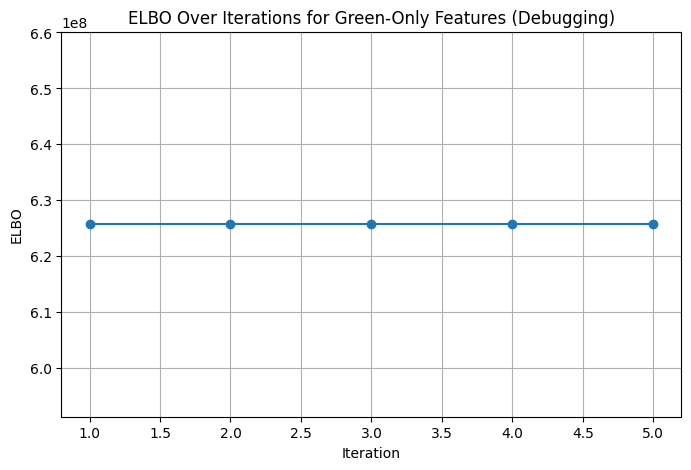

In [27]:
# ✅ Load features
features_green = np.load("green_channel_features.npy")
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")

# ✅ Check for NaNs
print("Checking for NaNs...")
features_green = np.nan_to_num(features_green)
features_pseudo_rgb = np.nan_to_num(features_pseudo_rgb)
features_grayscale = np.nan_to_num(features_grayscale)

# ✅ Sample a smaller subset of data
subset_size = 5000
features_green = features_green[:subset_size]
features_pseudo_rgb = features_pseudo_rgb[:subset_size]
features_grayscale = features_grayscale[:subset_size]

# ✅ Standardize features
scaler = StandardScaler()
features_green = scaler.fit_transform(features_green)
features_pseudo_rgb = scaler.transform(features_pseudo_rgb)
features_grayscale = scaler.transform(features_grayscale)

# ✅ DP-GMM Model Setup (Fixes Applied)
dpgmm = BayesianGaussianMixture(
    n_components=50,  
    weight_concentration_prior=1e-2,  
    weight_concentration_prior_type="dirichlet_process",
    covariance_type="full",
    reg_covar=1e-4,  
    init_params="kmeans",  
    n_init=1,  
    max_iter=5,  # ⬆ More iterations per fit
    warm_start=True,  
    tol=1e-4,  # ⬇ Reduce tolerance
    verbose=2,
    random_state=42
)

# ✅ Track ELBO per iteration
num_iterations = 5
elbo_values = []

# ✅ Check if `warm_start` is actually working
print("Warm Start Enabled:", dpgmm.warm_start)

previous_means = None  # Track mean changes

print("\nFitting DP-GMM on Green-Only Features with Manual Iteration Tracking...")
for i in range(num_iterations):
    dpgmm.lower_bound_ = -np.inf  # 🔄 Reset ELBO to force recomputation
    
    dpgmm.fit(features_green)  # Run one step of EM
    elbo_values.append(dpgmm.lower_bound_)
    
    # ✅ Check if means are changing
    if previous_means is not None:
        print(f"Iteration {i+1}, Mean Shift: {np.linalg.norm(dpgmm.means_ - previous_means)}")
    previous_means = np.copy(dpgmm.means_)
    
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

# ✅ Save ELBO values
np.save("dpgmm_elbo_green_debug.npy", elbo_values)

# 📊 Plot ELBO over iterations
plt.figure(figsize=(8,5))
plt.plot(range(1, num_iterations + 1), elbo_values, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Over Iterations for Green-Only Features (Debugging)")
plt.grid()
plt.show()

# ✅ Get cluster assignments
clusters_green = dpgmm.predict(features_green)
np.save("dpgmm_clusters_greenscidebug.npy", clusters_green)

ELBO as predicted, is massive. 

Fitting DP-GMM on Green-Only Features...
Initialization 0
Initialization converged. time lapse 598.94230s	 lower bound 2037295376.61571.
Fitting DP-GMM on Pseudo-RGB Features...
Initialization 0
Initialization converged. time lapse 594.75136s	 lower bound 1999060692.40529.
Fitting DP-GMM on Grayscale Features...
Initialization 0
Initialization converged. time lapse 594.87018s	 lower bound 2092653650.75965.

Clustering complete! Clusters found:
- Green-Only: 100 clusters
- Pseudo-RGB: 100 clusters
- Grayscale: 100 clusters


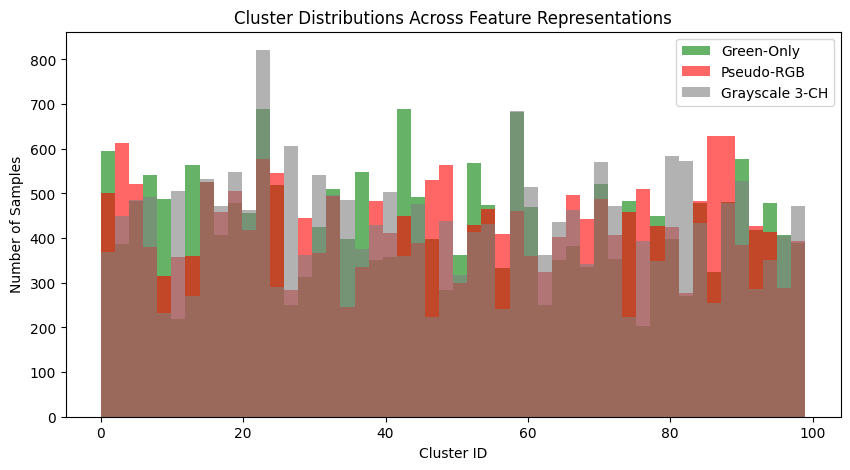

In [28]:
# Load all feature sets
features_green = np.load("green_channel_features.npy")      # (21806, 2048)
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")    # (21806, 2048)
features_grayscale = np.load("grayscale_3ch_features.npy")  # (21806, 2048)

# DP-GMM Model Setup
dpgmm = BayesianGaussianMixture(
    n_components=100,  # Max clusters, DP picks the optimal number
    covariance_type="full",
    weight_concentration_prior_type="dirichlet_process",
    verbose = 2,
    max_iter=5,
    random_state=42
)

# Run DP-GMM on Green Features
print("Fitting DP-GMM on Green-Only Features...")
dpgmm.fit(features_green)
clusters_green = dpgmm.predict(features_green)
np.save("dpgmm_clusters_greenscimk1.npy", clusters_green)

# Run DP-GMM on Pseudo-RGB Features
print("Fitting DP-GMM on Pseudo-RGB Features...")
dpgmm.fit(features_pseudo_rgb)
clusters_pseudo_rgb = dpgmm.predict(features_pseudo_rgb)
np.save("dpgmm_clusters_pseudo_rgbscimk1.npy", clusters_pseudo_rgb)

# Run DP-GMM on Grayscale Features
print("Fitting DP-GMM on Grayscale Features...")
dpgmm.fit(features_grayscale)
clusters_grayscale = dpgmm.predict(features_grayscale)
np.save("dpgmm_clusters_grayscalescimk1.npy", clusters_grayscale)

print("\nClustering complete! Clusters found:")
print(f"- Green-Only: {len(set(clusters_green))} clusters")
print(f"- Pseudo-RGB: {len(set(clusters_pseudo_rgb))} clusters")
print(f"- Grayscale: {len(set(clusters_grayscale))} clusters")

# 📊 Plot Cluster Distributions
plt.figure(figsize=(10,5))
plt.hist(clusters_green, bins=50, alpha=0.6, label="Green-Only", color="green")
plt.hist(clusters_pseudo_rgb, bins=50, alpha=0.6, label="Pseudo-RGB", color="red")
plt.hist(clusters_grayscale, bins=50, alpha=0.6, label="Grayscale 3-CH", color="gray")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")
plt.title("Cluster Distributions Across Feature Representations")
plt.legend()
plt.show()

Once again, ELBO is massive. 

## K-Means initialization, and sparsity, and preventing singularity and multiple runs

After altering the algorithm a bit, we shall see that the problem does not go away since it is based on the inherent non-Gaussanity of the data. Massive ELBO values are still expected. 

Checking for NaNs...

Fitting DP-GMM on Green-Only Features with Manual Iteration Tracking...
Initialization 0
Initialization converged. time lapse 599.60804s	 lower bound 1189608325.54588.
Iteration 1, ELBO: 1189608325.5458844
Initialization 0
Initialization converged. time lapse 230.34582s	 lower bound 1189608325.54588.
Iteration 2, ELBO: 1189608325.5458844
Initialization 0
Initialization converged. time lapse 230.35213s	 lower bound 1189608325.54588.
Iteration 3, ELBO: 1189608325.5458844
Initialization 0
Initialization converged. time lapse 229.88590s	 lower bound 1189608325.54588.
Iteration 4, ELBO: 1189608325.5458844
Initialization 0
Initialization converged. time lapse 230.25092s	 lower bound 1189608325.54588.
Iteration 5, ELBO: 1189608325.5458844


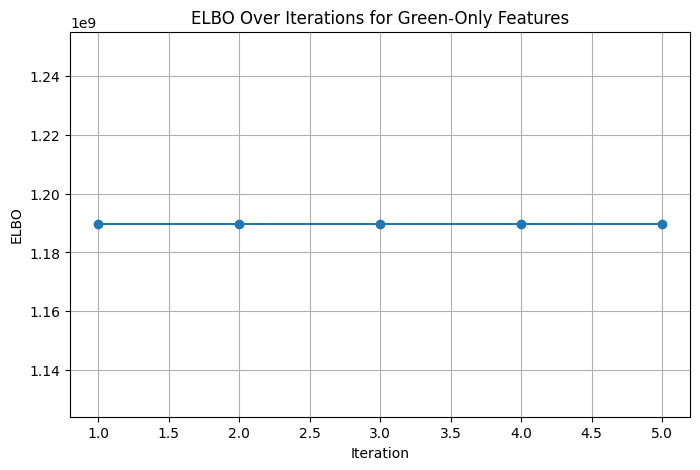


Fitting DP-GMM on Pseudo-RGB Features...
Initialization 0
Initialization did not converge. time lapse 1150.17311s	 lower bound 1220498519.94002.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1220498519.9400203
Initialization 0
Initialization did not converge. time lapse 1153.16041s	 lower bound 1220513751.53833.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 2, ELBO: 1220513751.538326
Initialization 0
Initialization did not converge. time lapse 1160.77295s	 lower bound 1220517097.48770.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 3, ELBO: 1220517097.4876952
Initialization 0
Initialization converged. time lapse 920.89045s	 lower bound 1220518530.84461.
Iteration 4, ELBO: 1220518530.844608
Initialization 0
Initialization converged. time lapse 229.50319s	 lower bound 1220518530.84481.
Iteration 5, ELBO: 1220518530.8448129

Fitting DP-GMM on Grayscale Features...
Initialization 0
Initialization converged. time lapse 460.04616s	 lower bound 1339589062.59197.
Iteration 1, ELBO: 1339589062.5919747
Initialization 0
Initialization converged. time lapse 230.05241s	 lower bound 1339589062.59197.
Iteration 2, ELBO: 1339589062.5919747
Initialization 0
Initialization converged. time lapse 229.42381s	 lower bound 1339589062.59197.
Iteration 3, ELBO: 1339589062.5919747
Initialization 0
Initialization converged. time lapse 230.60260s	 lower bound 1339589062.59197.
Iteration 4, ELBO: 1339589062.5919747
Initialization 0
Initialization converged. time lapse 230.52914s	 lower bound 1339589062.59197.
Iteration 5, ELBO: 133

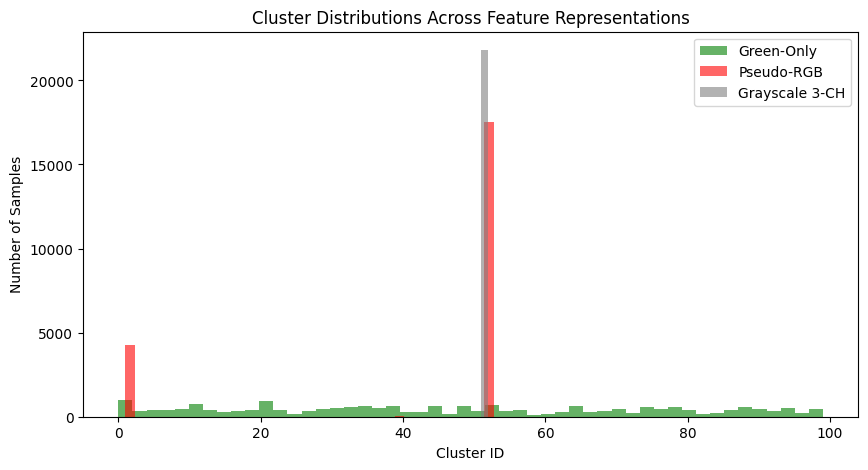

In [29]:
# ✅ Load features
features_green = np.load("green_channel_features.npy")
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")

# ✅ Check for NaNs
print("Checking for NaNs...")
features_green = np.nan_to_num(features_green)
features_pseudo_rgb = np.nan_to_num(features_pseudo_rgb)
features_grayscale = np.nan_to_num(features_grayscale)

# ✅ Standardize features
scaler = StandardScaler()
features_green = scaler.fit_transform(features_green)
features_pseudo_rgb = scaler.transform(features_pseudo_rgb)
features_grayscale = scaler.transform(features_grayscale)

# ✅ DP-GMM Model Setup
dpgmm = BayesianGaussianMixture(
    n_components=100,  # Maximum possible clusters
    weight_concentration_prior=1e-2,  # Controls sparsity
    weight_concentration_prior_type="dirichlet_process",  # ✅ Enables DP behavior
    covariance_type="full",
    reg_covar=1e-4,  # ✅ Prevent covariance collapse
    init_params="kmeans",  # ✅ Better initialization
    n_init=1,  # Single initialization for tracking
    max_iter=5,  # Run for multiple steps per update
    warm_start=True,  # ✅ Keep improving model instead of restarting
    tol=1e-3,  # ✅ Loosen tolerance for better convergence
    verbose=2,
    random_state=42
)
# ✅ Track ELBO per iteration
elbo_values = []
num_iterations = 5  # Set how many iterations you want to track manually

print("\nFitting DP-GMM on Green-Only Features with Manual Iteration Tracking...")
for i in range(num_iterations):
    dpgmm.fit(features_green)
    elbo_values.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

# ✅ Save ELBO values
np.save("dpgmm_elbo_greenmk2.npy", elbo_values)

# 📊 Plot ELBO over iterations
plt.figure(figsize=(8,5))
plt.plot(range(1, num_iterations + 1), elbo_values, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Over Iterations for Green-Only Features")
plt.grid()
plt.show()

# ✅ Get cluster assignments
clusters_green = dpgmm.predict(features_green)
np.save("dpgmm_clusters_greenscimk2.npy", clusters_green)

# ✅ Repeat for Pseudo-RGB Features
print("\nFitting DP-GMM on Pseudo-RGB Features...")
elbo_values_pseudo = []
for i in range(num_iterations):
    dpgmm.fit(features_pseudo_rgb)
    elbo_values_pseudo.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_pseudomk2.npy", elbo_values_pseudo)
clusters_pseudo_rgb = dpgmm.predict(features_pseudo_rgb)
np.save("dpgmm_clusters_pseudo_rgbscimk2.npy", clusters_pseudo_rgb)

# ✅ Repeat for Grayscale Features
print("\nFitting DP-GMM on Grayscale Features...")
elbo_values_gray = []
for i in range(num_iterations):
    dpgmm.fit(features_grayscale)
    elbo_values_gray.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_graymk2.npy", elbo_values_gray)
clusters_grayscale = dpgmm.predict(features_grayscale)
np.save("dpgmm_clusters_grayscalescimk2.npy", clusters_grayscale)

# 📊 Compare Cluster Distributions
plt.figure(figsize=(10,5))
plt.hist(clusters_green, bins=50, alpha=0.6, label="Green-Only", color="green")
plt.hist(clusters_pseudo_rgb, bins=50, alpha=0.6, label="Pseudo-RGB", color="red")
plt.hist(clusters_grayscale, bins=50, alpha=0.6, label="Grayscale 3-CH", color="gray")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")
plt.title("Cluster Distributions Across Feature Representations")
plt.legend()
plt.show()

ELBO is massive as expected since the data is non-Gaussian. 

Checking for NaNs...

Fitting DP-GMM on Green-Only Features with Manual Iteration Tracking...
Initialization 0
Initialization did not converge. time lapse 365.58762s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.71218s	 lower bound 1266264336.13035.
Iteration 2, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 229.97658s	 lower bound 1266264336.13035.
Iteration 3, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 229.73989s	 lower bound 1266264336.13035.
Iteration 4, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 229.41000s	 lower bound 1266264336.13035.
Iteration 5, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 229.89412s	 lower bound 1266264336.13035.
Iteration 6, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.81329s	 lower bound 1266264336.13035.
Iteration 7, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 229.43174s	 lower bound 1266264336.13035.
Iteration 8, ELBO: 1266264336.1303515
Initialization 0
Initial

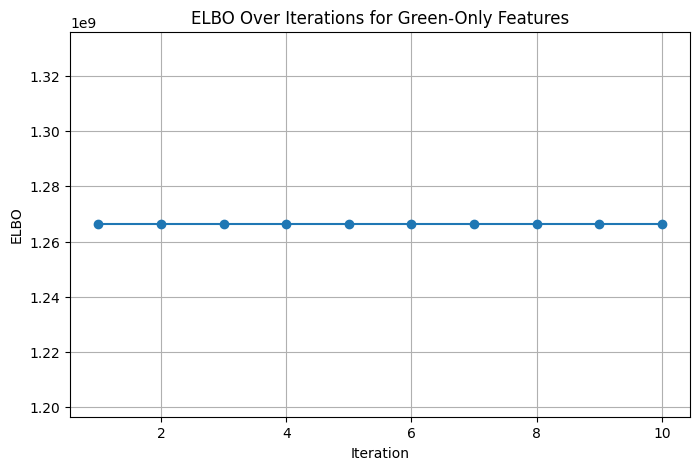


Fitting DP-GMM on Pseudo-RGB Features...
Initialization 0
Initialization did not converge. time lapse 230.06450s	 lower bound 1219520664.82568.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1219520664.8256803
Initialization 0
Initialization did not converge. time lapse 230.11395s	 lower bound 1219646550.09882.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 2, ELBO: 1219646550.0988193
Initialization 0
Initialization did not converge. time lapse 230.17915s	 lower bound 1219701453.52015.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 3, ELBO: 1219701453.520146
Initialization 0
Initialization did not converge. time lapse 230.17651s	 lower bound 1219738046.73589.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 4, ELBO: 1219738046.7358942
Initialization 0
Initialization did not converge. time lapse 230.00759s	 lower bound 1219751423.85632.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 5, ELBO: 1219751423.8563204
Initialization 0
Initialization did not converge. time lapse 229.77873s	 lower bound 1219754116.69644.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 6, ELBO: 1219754116.6964355
Initialization 0
Initialization did not converge. time lapse 229.69545s	 lower bound 1219755530.66782.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 7, ELBO: 1219755530.6678212
Initialization 0
Initialization did not converge. time lapse 231.01944s	 lower bound 1219758757.32664.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 8, ELBO: 1219758757.326641
Initialization 0
Initialization did not converge. time lapse 231.24817s	 lower bound 1219758797.24044.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 9, ELBO: 1219758797.2404354
Initialization 0
Initialization did not converge. time lapse 231.85117s	 lower bound 1219761695.59213.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 10, ELBO: 1219761695.5921311

Fitting DP-GMM on Grayscale Features...
Initialization 0
Initialization did not converge. time lapse 230.34363s	 lower bound 1339728690.07759.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.21473s	 lower bound 1339728690.07759.
Iteration 2, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.74897s	 lower bound 1339728690.07759.
Iteration 3, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 229.91745s	 lower bound 1339728690.07759.
Iteration 4, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 229.40981s	 lower bound 1339728690.07759.
Iteration 5, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.05984s	 lower bound 1339728690.07759.
Iteration 6, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.07826s	 lower bound 1339728690.07759.
Iteration 7, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.15794s	 lower bound 1339728690.07759.
Iteration 8, ELBO: 1339728690.0775898
Initialization 0
Initial

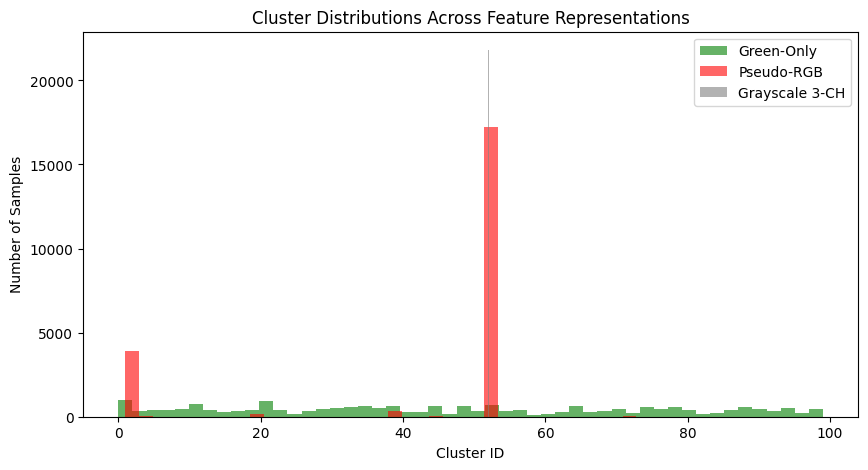

In [30]:
# ✅ Load features
features_green = np.load("green_channel_features.npy")
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")

# ✅ Check for NaNs
print("Checking for NaNs...")
features_green = np.nan_to_num(features_green)
features_pseudo_rgb = np.nan_to_num(features_pseudo_rgb)
features_grayscale = np.nan_to_num(features_grayscale)

# ✅ Standardize features
scaler = StandardScaler()
features_green = scaler.fit_transform(features_green)
features_pseudo_rgb = scaler.transform(features_pseudo_rgb)
features_grayscale = scaler.transform(features_grayscale)

# ✅ DP-GMM Model Setup
dpgmm = BayesianGaussianMixture(
    n_components=100,  # Maximum possible clusters
    weight_concentration_prior=1e-2,  # Controls sparsity
    weight_concentration_prior_type="dirichlet_process",  # ✅ Enables DP behavior
    covariance_type="full",
    reg_covar=1e-5,  # Prevents singularities
    init_params='kmeans',  # Better initialization
    n_init=1,  # Only one initialization since we're tracking iterations
    max_iter=1,  # Run only one iteration per step
    warm_start=True,  # ✅ Keeps updating the model instead of restarting
    verbose=2,
    random_state=42
)

# ✅ Track ELBO per iteration
elbo_values = []
num_iterations = 10  # Set how many iterations you want to track manually

print("\nFitting DP-GMM on Green-Only Features with Manual Iteration Tracking...")
for i in range(num_iterations):
    dpgmm.fit(features_green)
    elbo_values.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

# ✅ Save ELBO values
np.save("dpgmm_elbo_greenmk2r.npy", elbo_values)

# 📊 Plot ELBO over iterations
plt.figure(figsize=(8,5))
plt.plot(range(1, num_iterations + 1), elbo_values, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Over Iterations for Green-Only Features")
plt.grid()
plt.show()

# ✅ Get cluster assignments
clusters_green = dpgmm.predict(features_green)
np.save("dpgmm_clusters_greenscimk2r.npy", clusters_green)

# ✅ Repeat for Pseudo-RGB Features
print("\nFitting DP-GMM on Pseudo-RGB Features...")
elbo_values_pseudo = []
for i in range(num_iterations):
    dpgmm.fit(features_pseudo_rgb)
    elbo_values_pseudo.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_pseudomk2r.npy", elbo_values_pseudo)
clusters_pseudo_rgb = dpgmm.predict(features_pseudo_rgb)
np.save("dpgmm_clusters_pseudo_rgbscimk2r.npy", clusters_pseudo_rgb)

# ✅ Repeat for Grayscale Features
print("\nFitting DP-GMM on Grayscale Features...")
elbo_values_gray = []
for i in range(num_iterations):
    dpgmm.fit(features_grayscale)
    elbo_values_gray.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_graymk2r.npy", elbo_values_gray)
clusters_grayscale = dpgmm.predict(features_grayscale)
np.save("dpgmm_clusters_grayscalescimk2r.npy", clusters_grayscale)

# 📊 Compare Cluster Distributions
plt.figure(figsize=(10,5))
plt.hist(clusters_green, bins=50, alpha=0.6, label="Green-Only", color="green")
plt.hist(clusters_pseudo_rgb, bins=50, alpha=0.6, label="Pseudo-RGB", color="red")
plt.hist(clusters_grayscale, bins=50, alpha=0.6, label="Grayscale 3-CH", color="gray")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")
plt.title("Cluster Distributions Across Feature Representations")
plt.legend()
plt.show()

ELBO is still massive due to non-Gaussian data.

## Results:

ELBO is massive due to the non-Gaussian data. Whenever GMMs create massive ELBO values the underlying data should be tested for non-Gaussianity. The tests should be carried out before the GMM is run to see if GMM will cluster it anyways. 

## No K-Means Initialization

Without K-Means initialization the problem still does not disappear due to non-Gaussianity of the data. 

Checking for NaNs...

Fitting DP-GMM on Green-Only Features with Manual Iteration Tracking...
Initialization 0
Initialization did not converge. time lapse 366.07568s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 365.66736s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 2, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 364.57797s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 3, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 363.71713s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 4, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 364.67214s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 5, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 364.20022s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 6, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 364.62791s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 7, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 365.59965s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 8, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 364.22840s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 9, ELBO: 1266264336.1303515
Initialization 0
Initialization did not converge. time lapse 365.01914s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 10, ELBO: 1266264336.1303515


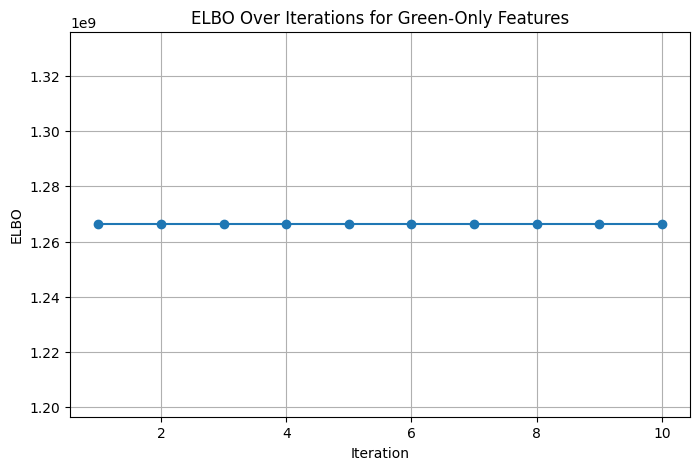


Fitting DP-GMM on Pseudo-RGB Features...
Initialization 0
Initialization did not converge. time lapse 365.07755s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 364.14773s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 2, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 366.89423s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 3, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 365.36335s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 4, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 365.30509s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 5, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 366.60853s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 6, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 364.68941s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 7, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 365.52672s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 8, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 364.92605s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 9, ELBO: 1224507075.0153687
Initialization 0
Initialization did not converge. time lapse 364.52981s	 lower bound 1224507075.01537.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 10, ELBO: 1224507075.0153687

Fitting DP-GMM on Grayscale Features...
Initialization 0
Initialization did not converge. time lapse 367.53256s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 366.72220s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 2, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 367.17090s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 3, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 366.66170s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 4, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 366.93639s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 5, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 369.86801s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 6, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 368.24704s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 7, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 367.52461s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 8, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 366.90170s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 9, ELBO: 1326518941.0743573
Initialization 0
Initialization did not converge. time lapse 366.34188s	 lower bound 1326518941.07436.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 10, ELBO: 1326518941.0743573


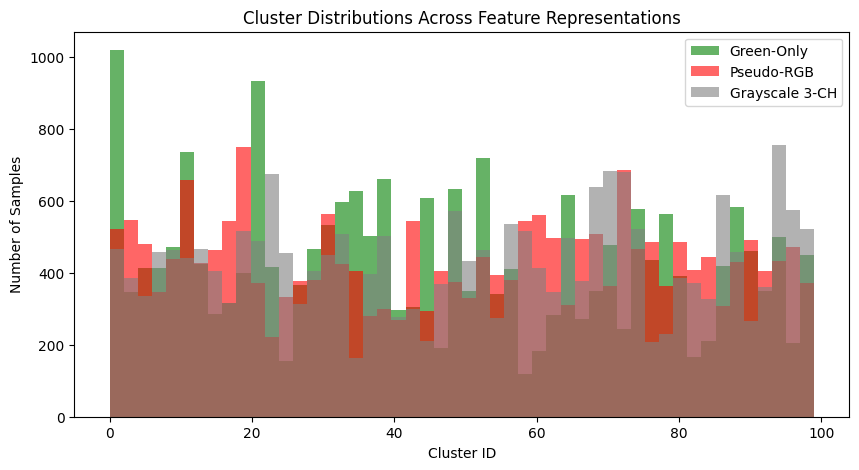

In [31]:
# ✅ Load features
features_green = np.load("green_channel_features.npy")
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")

# ✅ Check for NaNs
print("Checking for NaNs...")
features_green = np.nan_to_num(features_green)
features_pseudo_rgb = np.nan_to_num(features_pseudo_rgb)
features_grayscale = np.nan_to_num(features_grayscale)

# ✅ Standardize features
scaler = StandardScaler()
features_green = scaler.fit_transform(features_green)
features_pseudo_rgb = scaler.transform(features_pseudo_rgb)
features_grayscale = scaler.transform(features_grayscale)

# ✅ DP-GMM Model Setup (No Restart Between Iterations)
dpgmm = BayesianGaussianMixture(
    n_components=100,  # Maximum possible clusters
    weight_concentration_prior=1e-2,  # Controls sparsity
    weight_concentration_prior_type="dirichlet_process",  # ✅ Enables DP behavior
    covariance_type="full",
    reg_covar=1e-5,  # Prevents singularities
    n_init=1,  # Single initialization for tracking
    max_iter=1,  # Run one iteration at a time
   # warm_start=True,  # ✅ Keeps improving model instead of resetting
    verbose=2,
    random_state=42
)

# ✅ Track ELBO per iteration
num_iterations = 10  # Number of manual iterations
elbo_values = []

print("\nFitting DP-GMM on Green-Only Features with Manual Iteration Tracking...")
for i in range(num_iterations):
    dpgmm.fit(features_green)
    elbo_values.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

# ✅ Save ELBO values
np.save("dpgmm_elbo_green_mk3.npy", elbo_values)

# 📊 Plot ELBO over iterations
plt.figure(figsize=(8,5))
plt.plot(range(1, num_iterations + 1), elbo_values, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Over Iterations for Green-Only Features")
plt.grid()
plt.show()

# ✅ Get cluster assignments
clusters_green = dpgmm.predict(features_green)
np.save("dpgmm_clusters_greenscimk3.npy", clusters_green)

# ✅ Repeat for Pseudo-RGB Features
print("\nFitting DP-GMM on Pseudo-RGB Features...")
elbo_values_pseudo = []
for i in range(num_iterations):
    dpgmm.fit(features_pseudo_rgb)
    elbo_values_pseudo.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_pseudo_mk3.npy", elbo_values_pseudo)
clusters_pseudo_rgb = dpgmm.predict(features_pseudo_rgb)
np.save("dpgmm_clusters_pseudo_rgbscimk3.npy", clusters_pseudo_rgb)

# ✅ Repeat for Grayscale Features
print("\nFitting DP-GMM on Grayscale Features...")
elbo_values_gray = []
for i in range(num_iterations):
    dpgmm.fit(features_grayscale)
    elbo_values_gray.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_gray_mk3.npy", elbo_values_gray)
clusters_grayscale = dpgmm.predict(features_grayscale)
np.save("dpgmm_clusters_grayscalescimk3.npy", clusters_grayscale)

# 📊 Compare Cluster Distributions
plt.figure(figsize=(10,5))
plt.hist(clusters_green, bins=50, alpha=0.6, label="Green-Only", color="green")
plt.hist(clusters_pseudo_rgb, bins=50, alpha=0.6, label="Pseudo-RGB", color="red")
plt.hist(clusters_grayscale, bins=50, alpha=0.6, label="Grayscale 3-CH", color="gray")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")
plt.title("Cluster Distributions Across Feature Representations")
plt.legend()
plt.show()

ELBO is still massive due to non-Gaussian data. 

Checking for NaNs...

Fitting DP-GMM on Green-Only Features with Manual Iteration Tracking...
Initialization 0
Initialization did not converge. time lapse 365.76610s	 lower bound 1266264336.13035.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 231.41920s	 lower bound 1266264336.13035.
Iteration 2, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.59805s	 lower bound 1266264336.13035.
Iteration 3, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.21623s	 lower bound 1266264336.13035.
Iteration 4, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 231.54050s	 lower bound 1266264336.13035.
Iteration 5, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.97670s	 lower bound 1266264336.13035.
Iteration 6, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.41968s	 lower bound 1266264336.13035.
Iteration 7, ELBO: 1266264336.1303515
Initialization 0
Initialization converged. time lapse 230.68481s	 lower bound 1266264336.13035.
Iteration 8, ELBO: 1266264336.1303515
Initialization 0
Initial

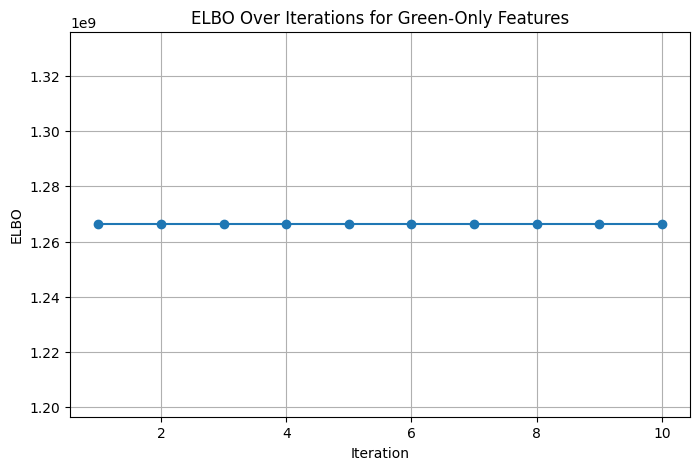


Fitting DP-GMM on Pseudo-RGB Features...
Initialization 0
Initialization did not converge. time lapse 230.22024s	 lower bound 1219520664.82568.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1219520664.8256803
Initialization 0
Initialization did not converge. time lapse 229.56651s	 lower bound 1219646550.09882.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 2, ELBO: 1219646550.0988193
Initialization 0
Initialization did not converge. time lapse 230.46653s	 lower bound 1219701453.52015.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 3, ELBO: 1219701453.520146
Initialization 0
Initialization did not converge. time lapse 230.78076s	 lower bound 1219738046.73589.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 4, ELBO: 1219738046.7358942
Initialization 0
Initialization did not converge. time lapse 230.54092s	 lower bound 1219751423.85632.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 5, ELBO: 1219751423.8563204
Initialization 0
Initialization did not converge. time lapse 230.16589s	 lower bound 1219754116.69644.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 6, ELBO: 1219754116.6964355
Initialization 0
Initialization did not converge. time lapse 230.90939s	 lower bound 1219755530.66782.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 7, ELBO: 1219755530.6678212
Initialization 0
Initialization did not converge. time lapse 230.84063s	 lower bound 1219758757.32664.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 8, ELBO: 1219758757.326641
Initialization 0
Initialization did not converge. time lapse 230.14490s	 lower bound 1219758797.24044.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 9, ELBO: 1219758797.2404354
Initialization 0
Initialization did not converge. time lapse 229.36413s	 lower bound 1219761695.59213.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 10, ELBO: 1219761695.5921311

Fitting DP-GMM on Grayscale Features...
Initialization 0
Initialization did not converge. time lapse 229.47364s	 lower bound 1339728690.07759.


C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Iteration 1, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.22743s	 lower bound 1339728690.07759.
Iteration 2, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 229.77352s	 lower bound 1339728690.07759.
Iteration 3, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 230.18015s	 lower bound 1339728690.07759.
Iteration 4, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 229.97253s	 lower bound 1339728690.07759.
Iteration 5, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 229.58681s	 lower bound 1339728690.07759.
Iteration 6, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 229.76704s	 lower bound 1339728690.07759.
Iteration 7, ELBO: 1339728690.0775898
Initialization 0
Initialization converged. time lapse 231.21409s	 lower bound 1339728690.07759.
Iteration 8, ELBO: 1339728690.0775898
Initialization 0
Initial

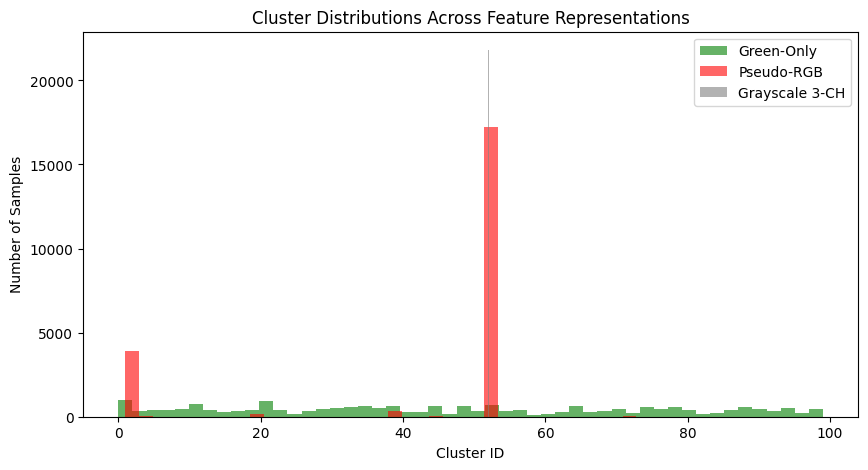

In [32]:
# ✅ Load features
features_green = np.load("green_channel_features.npy")
features_pseudo_rgb = np.load("pseudo_rgb_features.npy")
features_grayscale = np.load("grayscale_3ch_features.npy")

# ✅ Check for NaNs
print("Checking for NaNs...")
features_green = np.nan_to_num(features_green)
features_pseudo_rgb = np.nan_to_num(features_pseudo_rgb)
features_grayscale = np.nan_to_num(features_grayscale)

# ✅ Standardize features
scaler = StandardScaler()
features_green = scaler.fit_transform(features_green)
features_pseudo_rgb = scaler.transform(features_pseudo_rgb)
features_grayscale = scaler.transform(features_grayscale)

# ✅ DP-GMM Model Setup (No Restart Between Iterations)
dpgmm = BayesianGaussianMixture(
    n_components=100,  # Maximum possible clusters
    weight_concentration_prior=1e-2,  # Controls sparsity
    weight_concentration_prior_type="dirichlet_process",  # ✅ Enables DP behavior
    covariance_type="full",
    reg_covar=1e-5,  # Prevents singularities
    n_init=1,  # Single initialization for tracking
    max_iter=1,  # Run one iteration at a time
    warm_start=True,  # ✅ Keeps improving model instead of resetting
    verbose=2,
    random_state=42
)

# ✅ Track ELBO per iteration
num_iterations = 10  # Number of manual iterations
elbo_values = []

print("\nFitting DP-GMM on Green-Only Features with Manual Iteration Tracking...")
for i in range(num_iterations):
    dpgmm.fit(features_green)
    elbo_values.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

# ✅ Save ELBO values
np.save("dpgmm_elbo_green_mk3r.npy", elbo_values)

# 📊 Plot ELBO over iterations
plt.figure(figsize=(8,5))
plt.plot(range(1, num_iterations + 1), elbo_values, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Over Iterations for Green-Only Features")
plt.grid()
plt.show()

# ✅ Get cluster assignments
clusters_green = dpgmm.predict(features_green)
np.save("dpgmm_clusters_greenscimk3r.npy", clusters_green)

# ✅ Repeat for Pseudo-RGB Features
print("\nFitting DP-GMM on Pseudo-RGB Features...")
elbo_values_pseudo = []
for i in range(num_iterations):
    dpgmm.fit(features_pseudo_rgb)
    elbo_values_pseudo.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_pseudo_mk3r.npy", elbo_values_pseudo)
clusters_pseudo_rgb = dpgmm.predict(features_pseudo_rgb)
np.save("dpgmm_clusters_pseudo_rgbscimk3r.npy", clusters_pseudo_rgb)

# ✅ Repeat for Grayscale Features
print("\nFitting DP-GMM on Grayscale Features...")
elbo_values_gray = []
for i in range(num_iterations):
    dpgmm.fit(features_grayscale)
    elbo_values_gray.append(dpgmm.lower_bound_)
    print(f"Iteration {i+1}, ELBO: {dpgmm.lower_bound_}")

np.save("dpgmm_elbo_gray_mk3r.npy", elbo_values_gray)
clusters_grayscale = dpgmm.predict(features_grayscale)
np.save("dpgmm_clusters_grayscalescimk3r.npy", clusters_grayscale)

# 📊 Compare Cluster Distributions
plt.figure(figsize=(10,5))
plt.hist(clusters_green, bins=50, alpha=0.6, label="Green-Only", color="green")
plt.hist(clusters_pseudo_rgb, bins=50, alpha=0.6, label="Pseudo-RGB", color="red")
plt.hist(clusters_grayscale, bins=50, alpha=0.6, label="Grayscale 3-CH", color="gray")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Samples")
plt.title("Cluster Distributions Across Feature Representations")
plt.legend()
plt.show()

ELBO is still massive due to non-Gaussian data.

---

# Section 5: K-Means


K-Means requires a k-value, or the number of clusters to be set before running. K-Means is a hard clustering algorithm, which means each datapoint can only be in one cluster. For this reason the GMM was tested beforehand. In Chapter 10 of the Stanford CS229 Notes this algorithm is discussed in great detail. 

The method below is not part of the notes. Here, we run the K-Means algorithm on small subsets of the dataset. We search for the "Knee of the curve" to find the optimal k-value rather than guessing several k-values. When the optimal k-value is found we run K-Means on the entire dataset. 

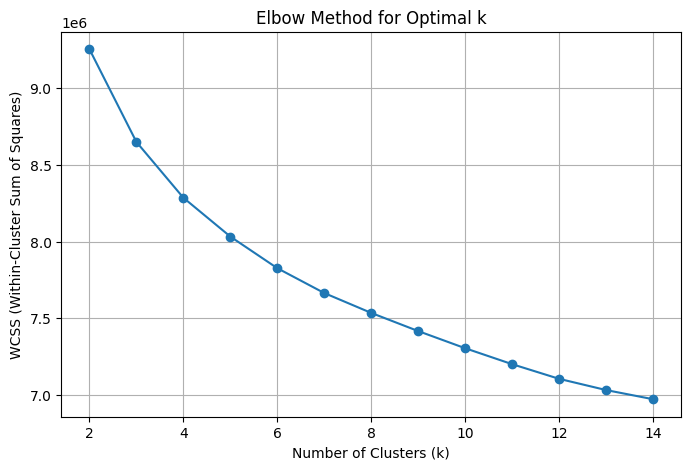

In [33]:
# ✅ Load features (Green Channel) 
features_green = np.load("green_channel_features.npy")  
# ✅ Sample a smaller subset 
subset_size = 5000 
features_green = features_green[:subset_size]  
# ✅ Standardize the features 
scaler = StandardScaler() 
features_green = scaler.fit_transform(features_green)  
# ✅ Try different values of k using the Elbow Method 
wcss = []  # Within-cluster sum of squares 
k_values = range(2, 15)  # Test k from 2 to 15  
for k in k_values:     
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)     
    kmeans.fit(features_green)     
    wcss.append(kmeans.inertia_)  # Store the sum of squared distances  
# 📊 Plot Elbow Method results 
plt.figure(figsize=(8, 5)) 
plt.plot(k_values, wcss, marker='o', linestyle='-') 
plt.xlabel("Number of Clusters (k)") 
plt.ylabel("WCSS (Within-Cluster Sum of Squares)") 
plt.title("Elbow Method for Optimal k") 
plt.grid() 
plt.show() 

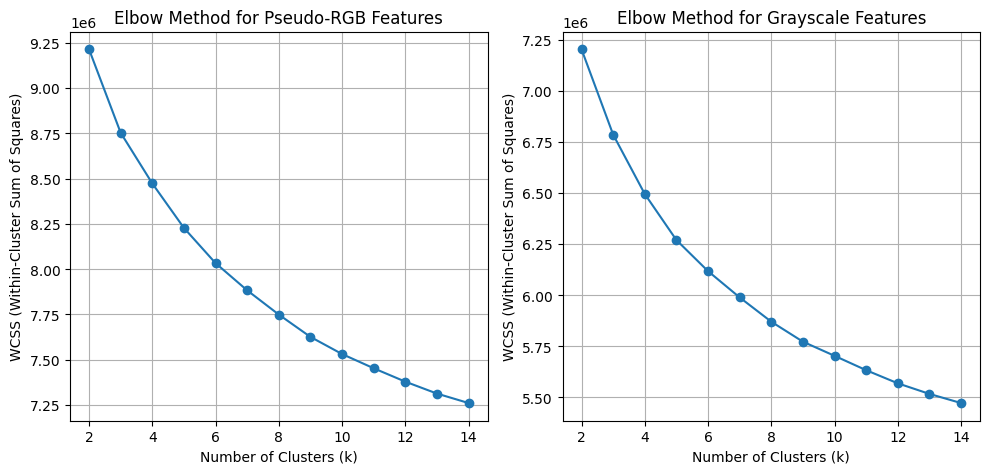

In [34]:
# ✅ Load features 
features_pseudo_rgb = np.load("pseudo_rgb_features.npy") 
features_grayscale = np.load("grayscale_3ch_features.npy")  
# ✅ Sample a subset (to speed up computation) 
subset_size = 5000 
features_pseudo_rgb = features_pseudo_rgb[:subset_size] 
features_grayscale = features_grayscale[:subset_size]  
# ✅ Standardize the features 
scaler = StandardScaler() 
features_pseudo_rgb = scaler.fit_transform(features_pseudo_rgb) 
features_grayscale = scaler.transform(features_grayscale)  
# ✅ Try different values of k using the Elbow Method 
k_values = range(2, 15)  # Testing k from 2 to 15  
# 📊 Run K-Means for Pseudo-RGB 
wcss_pseudo = [] 
for k in k_values:     
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)     
    kmeans.fit(features_pseudo_rgb)     
    wcss_pseudo.append(kmeans.inertia_)  
# 📊 Run K-Means for Grayscale 
wcss_gray = [] 
for k in k_values:     
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)     
    kmeans.fit(features_grayscale)     
    wcss_gray.append(kmeans.inertia_)  
# ✅ Plot the Elbow Method results for both 
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1) 
plt.plot(k_values, wcss_pseudo, marker='o', linestyle='-') 
plt.xlabel("Number of Clusters (k)") 
plt.ylabel("WCSS (Within-Cluster Sum of Squares)") 
plt.title("Elbow Method for Pseudo-RGB Features") 
plt.grid()  
plt.subplot(1, 2, 2) 
plt.plot(k_values, wcss_gray, marker='o', linestyle='-') 
plt.xlabel("Number of Clusters (k)") 
plt.ylabel("WCSS (Within-Cluster Sum of Squares)") 
plt.title("Elbow Method for Grayscale Features") 
plt.grid()  
plt.tight_layout() 
plt.show() 

Now the cluster k-values are chosen. They are k=7 for Green, k=8 for Pseudo-RGB, and k=9 for Grayscale. Next, the entire K-Means algorithm is run. The silhoutte scores are obtained and discussed below. 

Silhouette Score (Green): 0.06100311130285263
Silhouette Score (Pseudo-RGB): 0.05313834175467491
Silhouette Score (Grayscale): 0.05228627473115921


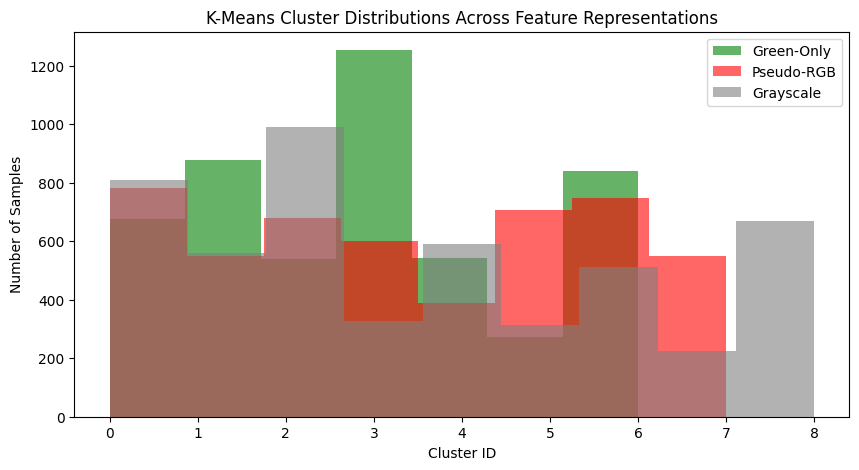

In [35]:
# ✅ Load features 
features_green = np.load("green_channel_features.npy") 
features_pseudo_rgb = np.load("pseudo_rgb_features.npy") 
features_grayscale = np.load("grayscale_3ch_features.npy")  
# ✅ Sample a subset (to speed up computation) 
subset_size = 5000 
features_green = features_green[:subset_size] 
features_pseudo_rgb = features_pseudo_rgb[:subset_size] 
features_grayscale = features_grayscale[:subset_size]  
# ✅ Standardize the features 
scaler = StandardScaler() 
features_green = scaler.fit_transform(features_green) 
features_pseudo_rgb = scaler.transform(features_pseudo_rgb) 
features_grayscale = scaler.transform(features_grayscale)  
# ✅ Run K-Means for Green Channel (k=7) 
kmeans_green = KMeans(n_clusters=7, random_state=42, n_init=10) 
clusters_green = kmeans_green.fit_predict(features_green) 
silhouette_green = silhouette_score(features_green, clusters_green)  
# ✅ Run K-Means for Pseudo-RGB (k=8) 
kmeans_pseudo = KMeans(n_clusters=8, random_state=42, n_init=10) 
clusters_pseudo = kmeans_pseudo.fit_predict(features_pseudo_rgb) 
silhouette_pseudo = silhouette_score(features_pseudo_rgb, clusters_pseudo)  
# ✅ Run K-Means for Grayscale (k=9) 
kmeans_gray = KMeans(n_clusters=9, random_state=42, n_init=10) 
clusters_gray = kmeans_gray.fit_predict(features_grayscale) 
silhouette_gray = silhouette_score(features_grayscale, clusters_gray)  
# ✅ Save cluster assignments 
np.save("kmeans_clusters_greentest.npy", clusters_green) 
np.save("kmeans_clusters_pseudotest.npy", clusters_pseudo) 
np.save("kmeans_clusters_graytest.npy", clusters_gray)  
# ✅ Print Silhouette Scores 
print(f"Silhouette Score (Green): {silhouette_green}") 
print(f"Silhouette Score (Pseudo-RGB): {silhouette_pseudo}") 
print(f"Silhouette Score (Grayscale): {silhouette_gray}")  
# 📊 Compare Cluster Distributions 
plt.figure(figsize=(10,5)) 
plt.hist(clusters_green, bins=7, alpha=0.6, label="Green-Only", color="green") 
plt.hist(clusters_pseudo, bins=8, alpha=0.6, label="Pseudo-RGB", color="red") 
plt.hist(clusters_gray, bins=9, alpha=0.6, label="Grayscale", color="gray") 
plt.xlabel("Cluster ID") 
plt.ylabel("Number of Samples") 
plt.title("K-Means Cluster Distributions Across Feature Representations") 
plt.legend() 
plt.show() 

Silhoutte scores vary between -1 and +1. It must be cohesive(or similar) to datapoints within its own cluster and seperated(or different) from the other clusters. 

- Greater than 0.7: Strong
- Over 0.5: Reasonable
- Over 0.25: Weak

As can be seen, the above silhoutte scores are all extremely small, hence K-Means did not do a good job of clustering.

---

# Section 6: DBSCAN

DBSCAN Silhouette Score (Green): -1
DBSCAN Silhouette Score (Pseudo-RGB): -1
DBSCAN Silhouette Score (Grayscale): -1


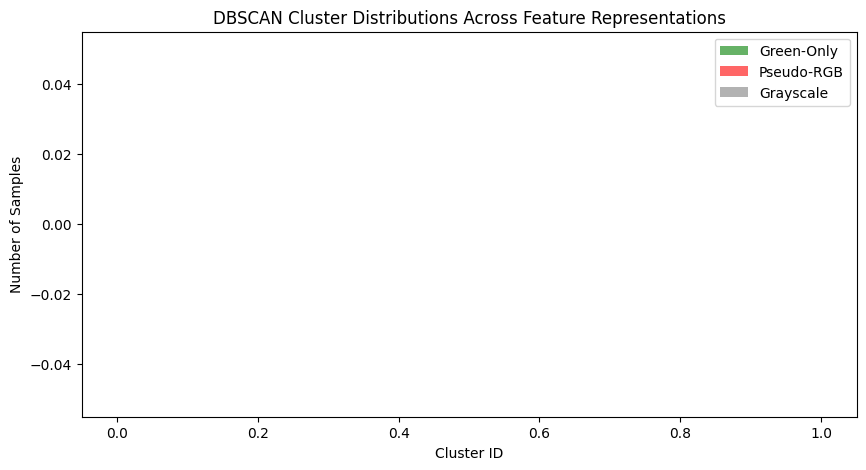

In [36]:
features_green = np.load("green_channel_features.npy") 
features_pseudo_rgb = np.load("pseudo_rgb_features.npy") 
features_grayscale = np.load("grayscale_3ch_features.npy")  
# ✅ Sample a subset (to speed up computation) 
subset_size = 5000 
features_green = features_green[:subset_size] 
features_pseudo_rgb = features_pseudo_rgb[:subset_size] 
features_grayscale = features_grayscale[:subset_size]  
# ✅ Standardize the features (DBSCAN is distance-based, so scaling is crucial) 
scaler = StandardScaler() 
features_green = scaler.fit_transform(features_green) 
features_pseudo_rgb = scaler.transform(features_pseudo_rgb) 
features_grayscale = scaler.transform(features_grayscale)  
# ✅ Set DBSCAN parameters (Will fine-tune later if needed) 
eps_value = 0.5  # Controls neighborhood size (will adjust if needed) 
min_samples_value = 10  # Minimum points per dense region  
# ✅ Run DBSCAN for Green Channel 
dbscan_green = DBSCAN(eps=eps_value, min_samples=min_samples_value, n_jobs=-1) 
clusters_green = dbscan_green.fit_predict(features_green) 
silhouette_green = silhouette_score(features_green, clusters_green) if len(set(clusters_green)) > 1 else -1  
# ✅ Run DBSCAN for Pseudo-RGB 
dbscan_pseudo = DBSCAN(eps=eps_value, min_samples=min_samples_value, n_jobs=-1) 
clusters_pseudo = dbscan_pseudo.fit_predict(features_pseudo_rgb) 
silhouette_pseudo = silhouette_score(features_pseudo_rgb, clusters_pseudo) if len(set(clusters_pseudo)) > 1 else -1  
# ✅ Run DBSCAN for Grayscale 
dbscan_gray = DBSCAN(eps=eps_value, min_samples=min_samples_value, n_jobs=-1) 
clusters_gray = dbscan_gray.fit_predict(features_grayscale) 
silhouette_gray = silhouette_score(features_grayscale, clusters_gray) if len(set(clusters_gray)) > 1 else -1  
# ✅ Save cluster assignments 
np.save("dbscan_clusters_green.npy", clusters_green) 
np.save("dbscan_clusters_pseudo.npy", clusters_pseudo) 
np.save("dbscan_clusters_gray.npy", clusters_gray)  
# ✅ Print Silhouette Scores 
print(f"DBSCAN Silhouette Score (Green): {silhouette_green}") 
print(f"DBSCAN Silhouette Score (Pseudo-RGB): {silhouette_pseudo}") 
print(f"DBSCAN Silhouette Score (Grayscale): {silhouette_gray}")  
# 📊 Compare Cluster Distributions (excluding noise points labeled as -1) 
plt.figure(figsize=(10,5)) 
plt.hist(clusters_green[clusters_green != -1], bins=20, alpha=0.6, label="Green-Only", color="green") 
plt.hist(clusters_pseudo[clusters_pseudo != -1], bins=20, alpha=0.6, label="Pseudo-RGB", color="red") 
plt.hist(clusters_gray[clusters_gray != -1], bins=20, alpha=0.6, label="Grayscale", color="gray") 
plt.xlabel("Cluster ID") 
plt.ylabel("Number of Samples") 
plt.title("DBSCAN Cluster Distributions Across Feature Representations") 
plt.legend() 
plt.show()  

As can be seen, DBSCAN clustered everything as noise, meaning that this dataset cannot be clustered by any of these algorithms. Some other algorithm must be used to train on this data, and my original hypothesis will not work. 

---
# Section 7: Citations

- Stanford CS229 Lecture Notes:
   https://cs229.stanford.edu/main_notes.pdf

- DPGMM
    https://mlg.eng.cam.ac.uk/pub/pdf/GoeRas10.pdf

- Silhoutte Scores:
    https://en.wikipedia.org/wiki/Silhouette_(clustering)

- DBSCAN
    https://en.wikipedia.org/wiki/DBSCAN

- Human Protein Atlas:
    https://www.kaggle.com/competitions/hpa-single-cell-image-classification